# Machine Learning Project - Credit Card Fraud

The aim of this project is to build a machine learning model to predict fraudulent credit card transactions. The model will be based on a public dataset available in Kaggle (link to dataset: https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction?resource=download).

# Context - Machine Learning in Fraud Detection

Fraud detection is one the fields machine learning can be applied and promote improvements. In the past, fraud detection relied upon rulesets to guide transaction assessment. However, a fixed set of rules is not the ideal way to approach the problem as they are slow to absorb the ever evolving methods to produce fraudulent transactions. In addition to being stationary, if they are too strict in order to try to prevent most frauds, they might block many genuine transactions and impact custormers' satisfaction (in machine learning terms, that is to produce a high number of false positives). The introduction of machines learning in this process has many benefits. Some of the advantages are speeding up the process of analysis, making fraud detection more scalable and allowing for dinamic adaptation to new ways of comitting fraud.

When using machine leraning, decisions can be taken after analysing the predicted chance of a given trasaction being a fraud. Transactions that fall bellow a given threeshold can be allowed to go through, while transactions that represents a certain risk can be sent to a team of human fraud analists to make a decision, and high risk can be automatically blocked. 

The ideal model has to look for a fine balance between accuracy, precision and recall. If the threeshold for allowing transactions is too low, high recall is expected (that is, most fraudulent transaction will be captured by the model), but many legitimate transaction will be blocked. If the threeshold is to high, recall will be lower, most legitimate transaction will be allowed, but so does some fraudulent. As most customers will become unsatisfied if they are having their legal transactions constantly blocked or delayed due to fraud assessment, this balance is crucial for maintaning efficient fraud detection and custormer experience.

Source: https://www.ravelin.com/insights/machine-learning-for-fraud-detection

In [6]:
# Import relevant packages

import pandas as pd # For converting results to a dataframe and creating plots
import numpy as np # For calculation and utils
import re # For retreving information from strings
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For data visualization
import datetime # For dealing with datetime
import eli5 # For model explanation
import shap # For model explanation

# For machine learning
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


%matplotlib inline

# The dataset

In [8]:
# Load data

data = pd.read_csv("credit_card_data.csv")

In [9]:
pd.set_option('display.max_columns', None)

# Inspect first few rows

data.head()

Unnamed: 0 trans_date_trans_time        cc_num  \
0           0      21/06/2020 12:14  2.291160e+15   
1           1      21/06/2020 12:14  3.573030e+15   
2           2      21/06/2020 12:14  3.598220e+15   
3           3      21/06/2020 12:15  3.591920e+15   
4           4      21/06/2020 12:15  3.526830e+15   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street        city state    zip  \
0   Elliott      M            351 Darlene Green    Columbia    SC  29209   
1  Williams      F             3638 Marsh Union     Altonah    UT  84002   
2     Lopez      F         9333 Valentine Point    Bellmore    NY  11710   
3  Williams      M  32941 Krystal Mill Apt. 552  Titusville    FL  32780   
4    Massey      M     5783 Evan Roads Apt. 465    Falmouth    MI  49632   

       lat      long  city_pop                     job         dob  \
0  33.9659  -80.9355    333497     Mechanical engineer  19/03/1968   
1  40.3207 -110.4360       302  Sales professional, IT  17/01/1990   
2  40.6729  -73.5365     34496       Librarian, public  21/10/1970   
3  28.5697  -80.8191     54767            Set designer  25/07/1987   
4  44.2529  -85.0170      1126      Furniture designer  06/07/1955   

                          trans_num   unix_time  merch_lat  merch_long  \
0  2da90c7d74bd46a0caf3777415b3ebd3  1371816865  33.986391  -81.200714   
1  324cc204407e99f51b0d6ca0055005e7  1371816873  39.450498 -109.960431   
2  c81755dbbbea9d5c77f094348a7579be  1371816893  40.495810  -74.196111   
3  2159175b9efe66dc301f149d3d5abf8c  1371816915  28.812398  -80.883061   
4  57ff021bd3f328f8738bb535c302a31b  1371816917  44.959148  -85.884734   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0

In [10]:
# Inspect data info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [11]:
# Drop 'Unnamed: 0' column
data = data.drop("Unnamed: 0", axis=1)

### Dataset summary

The data contains data about credit card transactions. It has a total of 555719 rows and 22 valid columns (column "Unnamed: 0" is not considered as it is the same as index). 

### Data dictionary
(Retrieved from https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction?resource=download)

**Trans_date_trans_time:** Timestamp of the transaction (date and time). \
**Cc_num:** Unique customer identification number. \
**Merchant:** The merchant involved in the transaction. \
**Category:** Transaction type (e.g., personal, childcare). \
**Amt:** Transaction amount. \
**First:** Cardholder's first name. \
**Last:** Cardholder's last name. \
**Gender:** Cardholder's gender. \
**Street:** Cardholder's street address. \
**City:** Cardholder's city of residence. \
**State:** Cardholder's state of  state of residence. \
**Zip:** Cardholder's zip code. \
**Lat:** Latitude of cardholder's location. \
**Long:** Longitude of cardholder's location. \
**City_pop:** Population of the cardholder's city. \
**Job:** Cardholder's job title. \
**Dob:** Cardholder's date of birth. \
**Trans_num:** Unique transaction identifier. \
**Unix_time:** Transaction timestamp (Unix format). \
**Merch_lat:** Merchant's location (latitude). \
**Merch_long:** Merchant's location (longitude). \
**Is_fraud:** Fraudulent transaction indicator (1 = fraud, 0 = legitimate). This is the target variable for classification purposes

# Data Cleaning

### 1. Check for duplicates and null values

In [15]:
# Check for duplicates

data.duplicated().sum()

0

In [16]:
# Check for missing values

data.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

There are neither duplicates nor null values in the dataset.

### 2. Correct variables' dtypes 

trans_date_trans_time (transaction time) should be turned from object into datatime. \
cc_num (credit card number) should be treated as string as it represent different credit cards. \
dob (date of brith) should be turned from from object into datatime. \
unix_time (transaction timestamp  in unix format) is redundant as it convey the same information as trans_date_trans_time and can be removed.

In [19]:
# Make a copy of the original dataset

data_cleaned = data.copy()

# Change the type of trans_date_trans_time to datatime

data_cleaned["trans_date_trans_time"] = pd.to_datetime(data_cleaned["trans_date_trans_time"], format="%d/%m/%Y %H:%M")

# Change the type of cc_num to str

data_cleaned["cc_num"] = data_cleaned["cc_num"].astype(str)
# Change the type of dob to datatime

data_cleaned["dob"] = pd.to_datetime(data_cleaned["dob"], format="%d/%m/%Y")

# Drop column "unix_time"

data_cleaned = data_cleaned.drop("unix_time", axis=1)

In [20]:
# Check if it worked

data_cleaned.head(10)

trans_date_trans_time              cc_num  \
0   2020-06-21 12:14:00  2291160000000000.0   
1   2020-06-21 12:14:00  3573030000000000.0   
2   2020-06-21 12:14:00  3598220000000000.0   
3   2020-06-21 12:15:00  3591920000000000.0   
4   2020-06-21 12:15:00  3526830000000000.0   
5   2020-06-21 12:15:00    30407700000000.0   
6   2020-06-21 12:15:00   213181000000000.0   
7   2020-06-21 12:15:00  3589290000000000.0   
8   2020-06-21 12:16:00  3596360000000000.0   
9   2020-06-21 12:16:00  3546900000000000.0   

                               merchant        category     amt     first  \
0                 fraud_Kirlin and Sons   personal_care    2.86      Jeff   
1                  fraud_Sporer-Keebler   personal_care   29.84    Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness   41.28    Ashley   
3                     fraud_Haley Group        misc_pos   60.05     Brian   
4                 fraud_Johnston-Casper          travel    3.19    Nathan   
5                   fraud_Daugherty LLC       kids_pets   19.55  Danielle   
6                   fraud_Romaguera Ltd  health_fitness  133.93     Kayla   
7                     fraud_Reichel LLC   personal_care   10.37     Paula   
8     fraud_Goyette, Howell and Collier    shopping_pos    4.37     David   
9                   fraud_Kilback Group     food_dining   66.54     Kayla   

       last gender                       street          city state    zip  \
0   Elliott      M            351 Darlene Green      Columbia    SC  29209   
1  Williams      F             3638 Marsh Union       Altonah    UT  84002   
2     Lopez      F         9333 Valentine Point      Bellmore    NY  11710   
3  Williams      M  32941 Krystal Mill Apt. 552    Titusville    FL  32780   
4    Massey      M     5783 Evan Roads Apt. 465      Falmouth    MI  49632   
5     Evans      F   76752 David Lodge Apt. 064     Breesport    NY  14816   
6    Sutton      F              010 Weaver Land      Carlotta    CA  95528   
7   Estrada      F              350 Stacy Glens       Spencer    SD  57374   
8   Everett      M              4138 David Fall    Morrisdale    PA  16858   
9    Obrien      F   7921 Robert Port Suite 343  Prairie Hill    TX  76678   

       lat      long  city_pop                                    job  \
0  33.9659  -80.9355    333497                    Mechanical engineer   
1  40.3207 -110.4360       302                 Sales professional, IT   
2  40.6729  -73.5365     34496                      Librarian, public   
3  28.5697  -80.8191     54767                           Set designer   
4  44.2529  -85.0170      1126                     Furniture designer   
5  42.1939  -76.7361       520                        Psychotherapist   
6  40.5070 -123.9743      1139                Therapist, occupational   
7  43.7557  -97.5936       343  Development worker, international aid   
8  41.0001  -78.2357      3688                          Advice worker   
9  31.6591  -96.8094       263                              Barrister   

         dob                         trans_num  merch_lat  merch_long  \
0 1968-03-19  2da90c7d74bd46a0caf3777415b3ebd3  33.986391  -81.200714   
1 1990-01-17  324cc204407e99f51b0d6ca0055005e7  39.450498 -109.960431   
2 1970-10-21  c81755dbbbea9d5c77f094348a7579be  40.495810  -74.196111   
3 1987-07-25  2159175b9efe66dc301f149d3d5abf8c  28.812398  -80.883061   
4 1955-07-06  57ff021bd3f328f8738bb535c302a31b  44.959148  -85.884734   
5 1991-10-13  798db04aaceb4febd084f1a7c404da93  41.747157  -77.584197   
6 1951-01-15  17003d7ce534440eadb10c4750e020e5  41.499458 -124.888729   
7 1972-03-05  8be473af4f05fc6146ea55ace73e7ca2  44.495498  -97.728453   
8 1973-05-27  71a1da150d1ce510193d7622e08e784e  41.546067  -78.120238   
9 1956-05-30  a7915132c7c4240996ba03a47f81e3bd  31.782919  -96.366185   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8         0  
9         0

In [21]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  object        
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  int64         
 12  lat                    555719 non-null  floa

### 3. Check for abnormal values

In [23]:
data_cleaned.describe()

trans_date_trans_time            amt            zip  \
count                         555719  555719.000000  555719.000000   
mean   2020-10-02 01:53:55.673389056      69.392810   48842.628015   
min              2020-06-21 12:14:00       1.000000    1257.000000   
25%              2020-08-09 06:10:00       9.630000   26292.000000   
50%              2020-10-03 00:59:00      47.290000   48174.000000   
75%              2020-12-01 03:02:30      83.010000   72011.000000   
max              2020-12-31 23:59:00   22768.110000   99921.000000   
std                              NaN     156.745941   26855.283328   

                 lat           long      city_pop  \
count  555719.000000  555719.000000  5.557190e+05   
mean       38.543253     -90.231325  8.822189e+04   
min        20.027100    -165.672300  2.300000e+01   
25%        34.668900     -96.798000  7.410000e+02   
50%        39.371600     -87.476900  2.408000e+03   
75%        41.894800     -80.175200  1.968500e+04   
max        65.689900     -67.950300  2.906700e+06   
std         5.061336      13.721780  3.003909e+05   

                                 dob      merch_lat     merch_long  \
count                         555719  555719.000000  555719.000000   
mean   1973-11-11 16:30:05.937173264      38.542798     -90.231380   
min              1924-10-30 00:00:00      19.027422    -166.671575   
25%              1962-09-27 00:00:00      34.755302     -96.905129   
50%              1975-11-30 00:00:00      39.376593     -87.445204   
75%              1987-04-23 00:00:00      41.954163     -80.264637   
max              2005-01-29 00:00:00      66.679297     -66.952026   
std                              NaN       5.095829      13.733071   

            is_fraud  
count  555719.000000  
mean        0.003860  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  
std         0.062008

In [24]:
data_cleaned.describe(include="all")

trans_date_trans_time              cc_num           merchant  \
count                          555719              555719             555719   
unique                            NaN                 904                693   
top                               NaN  6011370000000000.0  fraud_Kilback LLC   
freq                              NaN                2144               1859   
mean    2020-10-02 01:53:55.673389056                 NaN                NaN   
min               2020-06-21 12:14:00                 NaN                NaN   
25%               2020-08-09 06:10:00                 NaN                NaN   
50%               2020-10-03 00:59:00                 NaN                NaN   
75%               2020-12-01 03:02:30                 NaN                NaN   
max               2020-12-31 23:59:00                 NaN                NaN   
std                               NaN                 NaN                NaN   

             category            amt        first    last  gender  \
count          555719  555719.000000       555719  555719  555719   
unique             14            NaN          341     471       2   
top     gas_transport            NaN  Christopher   Smith       F   
freq            56370            NaN        11443   12146  304886   
mean              NaN      69.392810          NaN     NaN     NaN   
min               NaN       1.000000          NaN     NaN     NaN   
25%               NaN       9.630000          NaN     NaN     NaN   
50%               NaN      47.290000          NaN     NaN     NaN   
75%               NaN      83.010000          NaN     NaN     NaN   
max               NaN   22768.110000          NaN     NaN     NaN   
std               NaN     156.745941          NaN     NaN     NaN   

                 street        city   state            zip            lat  \
count            555719      555719  555719  555719.000000  555719.000000   
unique              924         849      50            NaN            NaN   
top     444 Robert Mews  Birmingham      TX            NaN            NaN   
freq               1474        2423   40393            NaN            NaN   
mean                NaN         NaN     NaN   48842.628015      38.543253   
min                 NaN         NaN     NaN    1257.000000      20.027100   
25%                 NaN         NaN     NaN   26292.000000      34.668900   
50%                 NaN         NaN     NaN   48174.000000      39.371600   
75%                 NaN         NaN     NaN   72011.000000      41.894800   
max                 NaN         NaN     NaN   99921.000000      65.689900   
std                 NaN         NaN     NaN   26855.283328       5.061336   

                 long      city_pop                job  \
count   555719.000000  5.557190e+05             555719   
unique            NaN           NaN                478   
top               NaN           NaN  Film/video editor   
freq              NaN           NaN               4119   
mean       -90.231325  8.822189e+04                NaN   
min       -165.672300  2.300000e+01                NaN   
25%        -96.798000  7.410000e+02                NaN   
50%        -87.476900  2.408000e+03                NaN   
75%        -80.175200  1.968500e+04                NaN   
max        -67.950300  2.906700e+06                NaN   
std         13.721780  3.003909e+05                NaN   

                                  dob                         trans_num  \
count                          555719                            555719   
unique                            NaN                            555719   
top                               NaN  2da90c7d74bd46a0caf3777415b3ebd3   
freq                              NaN                                 1   
mean    1973-11-11 16:30:05.937173264                               NaN   
min               1924-10-30 00:00:00                               NaN   
25%               1962-09-27 00:00:00                               NaN   
50% 

At first glance, the only value that calls for attention is the maximum value for transaction ammount. However, it is not unreasonable that some transactions deal with a large sum of money, which may even be a important factor to consider in the context of fraud detection.

### Data cleaning summary
There are neither duplicates nor null values in the dataset. Column types were corrected to reflect underlying data. The column 'amt' (refering to transaction amount) has some abnormal large values, but they will be kept for now as they may be important for fraud dection and will be explored further during Exploratory Data Analysis.

There are some personal data that should be dropped before modeling (i. e. customers' first and last name), but feature engineering can take place before dropping data attributes.

# Feature engineering

In this section, we will create new atributes for the dataset. Firstly, this will be done by extracting features regarding time from the trans_date_trans_time that may have a relationship with fraudulent transactions will be created (such as month, hour, day of the week). Also, it might be useful to create a feature that represent the cardholder age at the time of transaction. Finally, since we have the latitude and longitue of cardholder's and the merchant location, we can create one feature that accounts for the distance between cardholder and merchant.

In [28]:
# Extract features regarding time from the trans_date_trans_time

df_cc = data_cleaned.copy()
df_cc["year"] = df_cc["trans_date_trans_time"].dt.year
df_cc["month"] = df_cc["trans_date_trans_time"].dt.month
df_cc["hour"] = df_cc["trans_date_trans_time"].dt.hour
df_cc["weekday"] = df_cc["trans_date_trans_time"].dt.weekday # 0 is monday, 6 is sunday

# Create lat_dist and long dist to represent distance from custormer to merchant

df_cc["lat_dist"] =  abs(df_cc["lat"] - df_cc["merch_lat"])
df_cc["long_dist"] =  abs(df_cc["long"] - df_cc["merch_long"])

# Crete age to represent the age of the customer

df_cc["age"] = df_cc["trans_date_trans_time"].dt.year - df_cc["dob"].dt.year # age of the customer at the moment of the transaction

In [29]:
df_cc.head(10)

trans_date_trans_time              cc_num  \
0   2020-06-21 12:14:00  2291160000000000.0   
1   2020-06-21 12:14:00  3573030000000000.0   
2   2020-06-21 12:14:00  3598220000000000.0   
3   2020-06-21 12:15:00  3591920000000000.0   
4   2020-06-21 12:15:00  3526830000000000.0   
5   2020-06-21 12:15:00    30407700000000.0   
6   2020-06-21 12:15:00   213181000000000.0   
7   2020-06-21 12:15:00  3589290000000000.0   
8   2020-06-21 12:16:00  3596360000000000.0   
9   2020-06-21 12:16:00  3546900000000000.0   

                               merchant        category     amt     first  \
0                 fraud_Kirlin and Sons   personal_care    2.86      Jeff   
1                  fraud_Sporer-Keebler   personal_care   29.84    Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness   41.28    Ashley   
3                     fraud_Haley Group        misc_pos   60.05     Brian   
4                 fraud_Johnston-Casper          travel    3.19    Nathan   
5                   fraud_Daugherty LLC       kids_pets   19.55  Danielle   
6                   fraud_Romaguera Ltd  health_fitness  133.93     Kayla   
7                     fraud_Reichel LLC   personal_care   10.37     Paula   
8     fraud_Goyette, Howell and Collier    shopping_pos    4.37     David   
9                   fraud_Kilback Group     food_dining   66.54     Kayla   

       last gender                       street          city state    zip  \
0   Elliott      M            351 Darlene Green      Columbia    SC  29209   
1  Williams      F             3638 Marsh Union       Altonah    UT  84002   
2     Lopez      F         9333 Valentine Point      Bellmore    NY  11710   
3  Williams      M  32941 Krystal Mill Apt. 552    Titusville    FL  32780   
4    Massey      M     5783 Evan Roads Apt. 465      Falmouth    MI  49632   
5     Evans      F   76752 David Lodge Apt. 064     Breesport    NY  14816   
6    Sutton      F              010 Weaver Land      Carlotta    CA  95528   
7   Estrada      F              350 Stacy Glens       Spencer    SD  57374   
8   Everett      M              4138 David Fall    Morrisdale    PA  16858   
9    Obrien      F   7921 Robert Port Suite 343  Prairie Hill    TX  76678   

       lat      long  city_pop                                    job  \
0  33.9659  -80.9355    333497                    Mechanical engineer   
1  40.3207 -110.4360       302                 Sales professional, IT   
2  40.6729  -73.5365     34496                      Librarian, public   
3  28.5697  -80.8191     54767                           Set designer   
4  44.2529  -85.0170      1126                     Furniture designer   
5  42.1939  -76.7361       520                        Psychotherapist   
6  40.5070 -123.9743      1139                Therapist, occupational   
7  43.7557  -97.5936       343  Development worker, international aid   
8  41.0001  -78.2357      3688                          Advice worker   
9  31.6591  -96.8094       263                              Barrister   

         dob                         trans_num  merch_lat  merch_long  \
0 1968-03-19  2da90c7d74bd46a0caf3777415b3ebd3  33.986391  -81.200714   
1 1990-01-17  324cc204407e99f51b0d6ca0055005e7  39.450498 -109.960431   
2 1970-10-21  c81755dbbbea9d5c77f094348a7579be  40.495810  -74.196111   
3 1987-07-25  2159175b9efe66dc301f149d3d5abf8c  28.812398  -80.883061   
4 1955-07-06  57ff021bd3f328f8738bb535c302a31b  44.959148  -85.884734   
5 1991-10-13  798db04aaceb4febd084f1a7c404da93  41.747157  -77.584197   
6 1951-01-15  17003d7ce534440eadb10c4750e020e5  41.499458 -124.888729   
7 1972-03-05  8be473af4f05fc6146ea55ace73e7ca2  44.495498  -97.728453   
8 1973-05-27  71a1da150d1ce510193d7622e08e784e  41.546067  -78.120238   
9 1956-05-30  a7915132c7c4240996ba03a47f81e3bd  31.782919  -96.366185   

   is_fraud  year  month  hour  weekday  lat_dist  long_dist  age  
0         0  2020      6    12        6  0.020491   0.265214   52  
1         0  2020      6    12   

In [30]:
# Inspect values in the newly created columns

df_cc[["year", "month", "hour", "weekday", "lat_dist", "long_dist", "age"]].describe()

year          month           hour        weekday      lat_dist  \
count  555719.0  555719.000000  555719.000000  555719.000000  5.557190e+05   
mean     2020.0       9.508536      12.809062       2.726779  5.002834e-01   
std         0.0       1.978205       6.810924       2.178681  2.885699e-01   
min      2020.0       6.000000       0.000000       0.000000  1.000000e-06   
25%      2020.0       8.000000       7.000000       1.000000  2.501475e-01   
50%      2020.0      10.000000      14.000000       2.000000  5.010060e-01   
75%      2020.0      12.000000      19.000000       5.000000  7.500055e-01   
max      2020.0      12.000000      23.000000       6.000000  9.999970e-01   

           long_dist            age  
count  555719.000000  555719.000000  
mean        0.500164      46.636237  
std         0.288728      17.418528  
min         0.000005      15.000000  
25%         0.250180      33.000000  
50%         0.500104      45.000000  
75%         0.750386      58.000000  
max         0.999999      96.000000

Values in the columns created seem to be adequate. As the columns "year" only has one value (2020) it does not add information and will be dropped. Also the columns trans_date_trans_time is now redundant and can be dropped. It also worth noting that months from January to May are not represented in this dataset.

In [32]:
df_cc = df_cc.drop(["trans_date_trans_time", "year"], axis=1)

### Feature engineering summary
The columns "month", "weekday", "hour", "lat_dist", "long_dist" and "age" were added to the dataset.
**Month:** Month at which the transaction takes place. \
**Weekday:** Weekday at which the transaction takes place (0 = Monday, 6 = Sunday).  \
**Hour:** Hour at which the transaction takes place. \
**Lat_dist:** Distance of latitude between cardholder and merchant (absolute difference). \
**Long_dist:** Distance of longitude between buyer and merchant (absolute difference). \
**Age:** Age of the cardholder at the moment of the transaction.

# Exploratory Data Analysis
In this section we will explore the distribution of the variables in the dataset and their relationship with the targe variable "is fraud".

### Target variable distribution

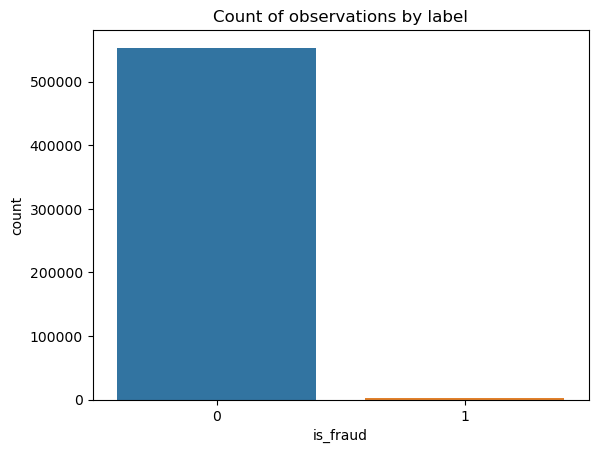

In [1017]:
sns.countplot(data=df_cc, x="is_fraud")
plt.title("Count of observations by label");

In [37]:
df_cc["is_fraud"].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

The dataset is very unbalaced, as most observation refer to non-fraudulent transactions (label "0": 553574 observations; label "1": 2145 observations).

### Dataset variables' distributions

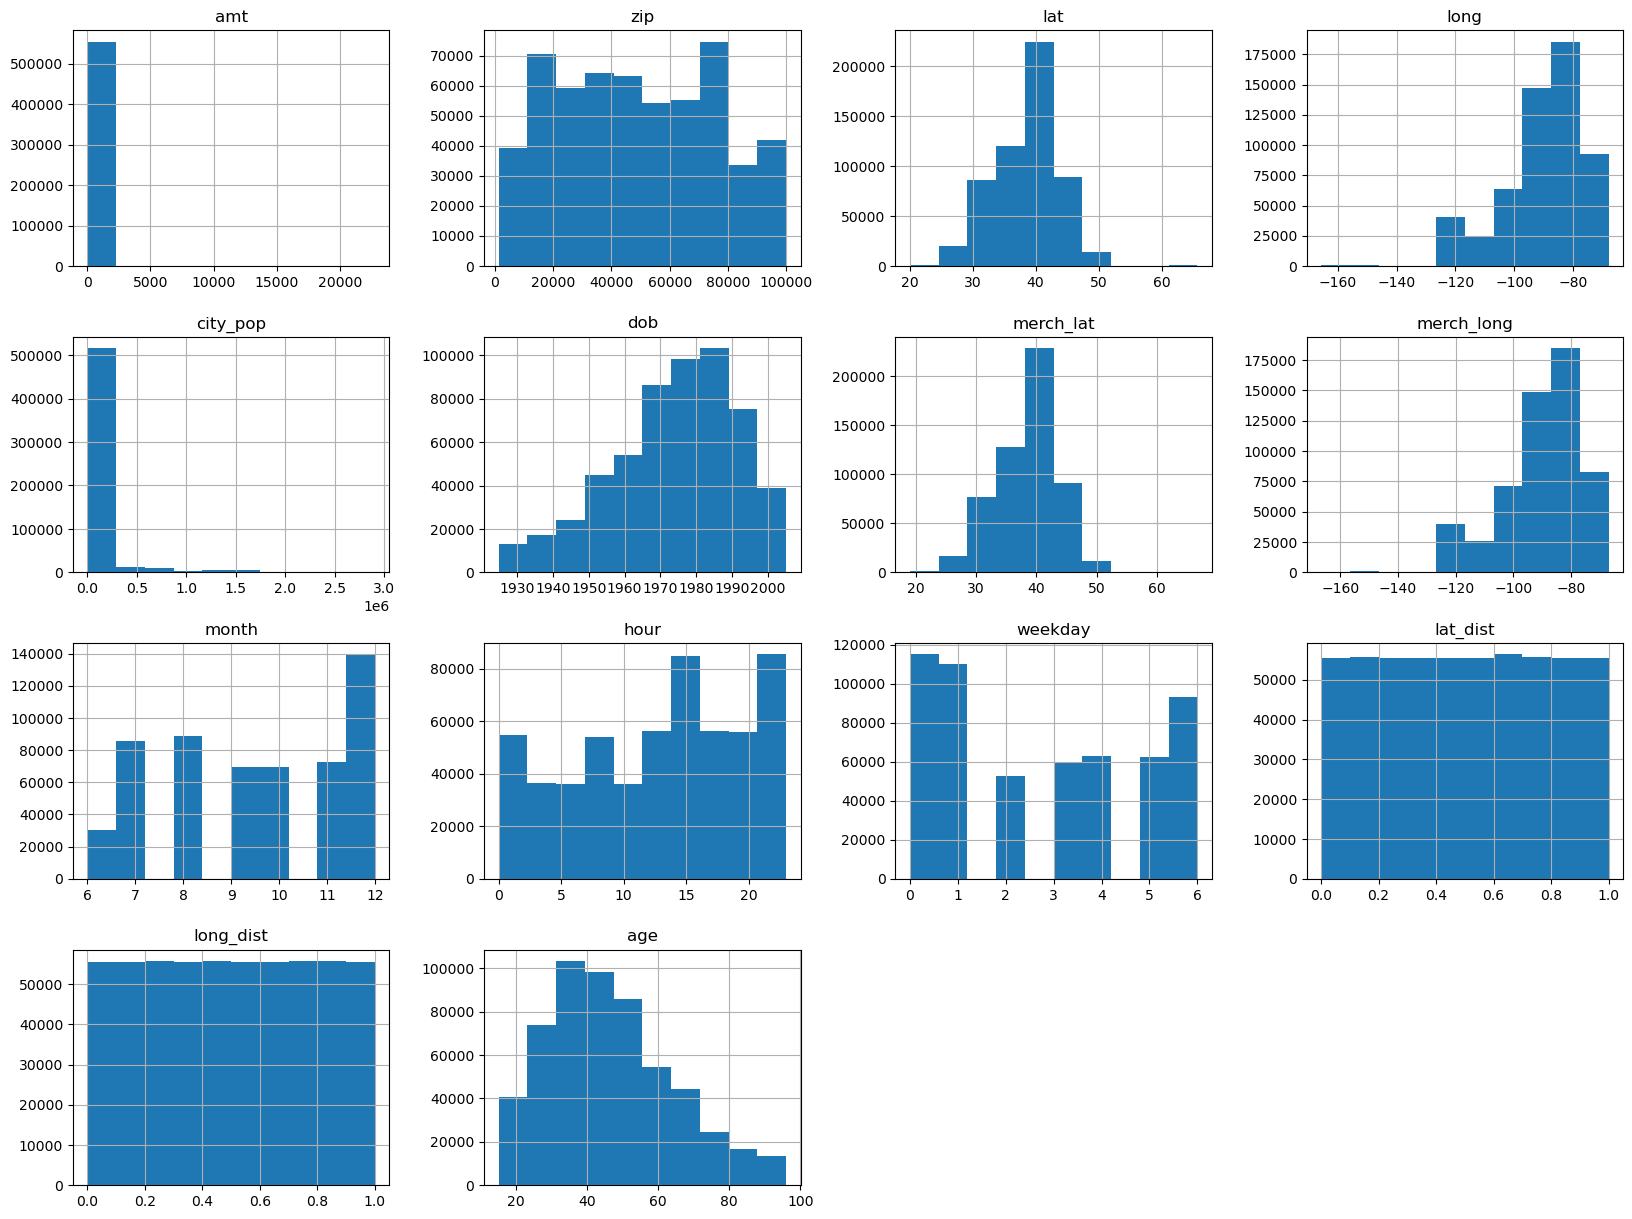

In [157]:
# Numeric variables distribution

df_cc.drop("is_fraud", axis=1).hist(figsize=(20,15));

In [41]:
df_categorical = df_cc.select_dtypes(include='object').drop(["cc_num", "first", "last", "street", "trans_num"], axis=1)
for col in df_categorical.columns:
    print(df_categorical[col].value_counts().to_string())  

merchant
fraud_Kilback LLC                              1859
fraud_Cormier LLC                              1597
fraud_Schumm PLC                               1561
fraud_Kuhn LLC                                 1521
fraud_Dickinson Ltd                            1519
fraud_Boyer PLC                                1506
fraud_Emard Inc                                1226
fraud_Parisian and Sons                        1202
fraud_Corwin-Collins                           1178
fraud_Streich, Hansen and Veum                 1168
fraud_Robel, Cummerata and Prosacco            1165
fraud_Schaefer, McGlynn and Bosco              1163
fraud_Zieme, Bode and Dooley                   1160
fraud_Huels-Hahn                               1157
fraud_Kling Inc                                1154
fraud_Raynor, Feest and Miller                 1152
fraud_Reilly, Heaney and Cole                  1147
fraud_Ledner-Pfannerstill                      1145
fraud_Mraz-Herzog                              1142
fra

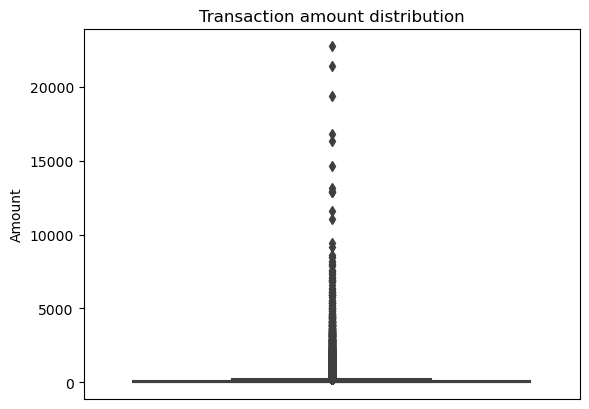

In [42]:
# Boxplot of 'amt' collumn

plt.Figure(figsize=(10,10))
sns.boxplot(data=df_cc['amt'])
plt.title("Transaction amount distribution")
plt.xticks([])
plt.ylabel("Amount");

### Target variable relationship with other numerical variables

<Axes: >

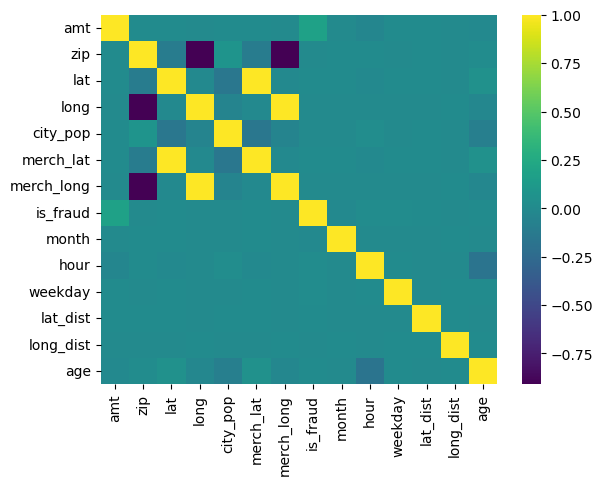

In [165]:
# Correlation heatmap

plt.figsize=(40, 20)
sns.heatmap(df_cc.corr(numeric_only=True), cmap="viridis")

In [45]:
# Correlatiton values

df_cc.corr(numeric_only=True)

amt       zip       lat      long  city_pop  merch_lat  \
amt         1.000000  0.002310  0.002339 -0.002046  0.002760   0.002404   
zip         0.002310  1.000000 -0.115173 -0.909942  0.075571  -0.114809   
lat         0.002339 -0.115173  1.000000 -0.012892 -0.152666   0.993557   
long       -0.002046 -0.909942 -0.012892  1.000000 -0.051524  -0.012551   
city_pop    0.002760  0.075571 -0.152666 -0.051524  1.000000  -0.151703   
merch_lat   0.002404 -0.114809  0.993557 -0.012551 -0.151703   1.000000   
merch_long -0.002053 -0.909117 -0.012831  0.999115 -0.051489  -0.012496   
is_fraud    0.182267 -0.002271  0.005863 -0.000972 -0.004910   0.005812   
year             NaN       NaN       NaN       NaN       NaN        NaN   
month      -0.000717  0.001401  0.000686 -0.001510 -0.001117   0.000750   
hour       -0.029860  0.005966 -0.010676 -0.001595  0.018937  -0.010512   
weekday     0.003414 -0.000075  0.001093  0.000099 -0.002010   0.001199   
lat_dist    0.002149  0.000579  0.000598 -0.000131  0.001389   0.000532   
long_dist  -0.001565 -0.000182 -0.001809  0.000497 -0.001230  -0.001650   
age        -0.012865  0.008823  0.045446 -0.027613 -0.089932   0.045100   

            merch_long  is_fraud  year     month      hour   weekday  \
amt          -0.002053  0.182267   NaN -0.000717 -0.029860  0.003414   
zip          -0.909117 -0.002271   NaN  0.001401  0.005966 -0.000075   
lat          -0.012831  0.005863   NaN  0.000686 -0.010676  0.001093   
long          0.999115 -0.000972   NaN -0.001510 -0.001595  0.000099   
city_pop     -0.051489 -0.004910   NaN -0.001117  0.018937 -0.002010   
merch_lat    -0.012496  0.005812   NaN  0.000750 -0.010512  0.001199   
merch_long    1.000000 -0.001060   NaN -0.001526 -0.001639  0.000074   
is_fraud     -0.001060  1.000000   NaN -0.011748  0.011686  0.009365   
year               NaN       NaN   NaN       NaN       NaN       NaN   
month        -0.001526 -0.011748   NaN  1.000000 -0.004995 -0.004090   
hour         -0.001639  0.011686   NaN -0.004995  1.000000  0.001516   
weekday       0.000074  0.009365   NaN -0.004090  0.001516  1.000000   
lat_dist     -0.000140  0.000978   NaN -0.001427  0.000065 -0.001232   
long_dist     0.000488 -0.000293   NaN  0.000738 -0.000576  0.000472   
age          -0.027645  0.007513   NaN -0.001408 -0.173491  0.004226   

            lat_dist  long_dist       age  
amt         0.002149  -0.001565 -0.012865  
zip         0.000579  -0.000182  0.008823  
lat         0.000598  -0.001809  0.045446  
long       -0.000131   0.000497 -0.027613  
city_pop    0.001389  -0.001230 -0.089932  
merch_lat   0.000532  -0.001650  0.045100  
merch_long -0.000140   0.000488 -0.027645  
is_fraud    0.000978  -0.000293  0.007513  
year             NaN        NaN       NaN  
month      -0.001427   0.000738 -0.001408  
hour        0.000065  -0.000576 -0.173491  
weekday    -0.001232   0.000472  0.004226  
lat_dist    1.000000   0.000329 -0.000979  
long_dist   0.000329   1.000000  0.002128  
age        -0.000979   0.002128  1.000000

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

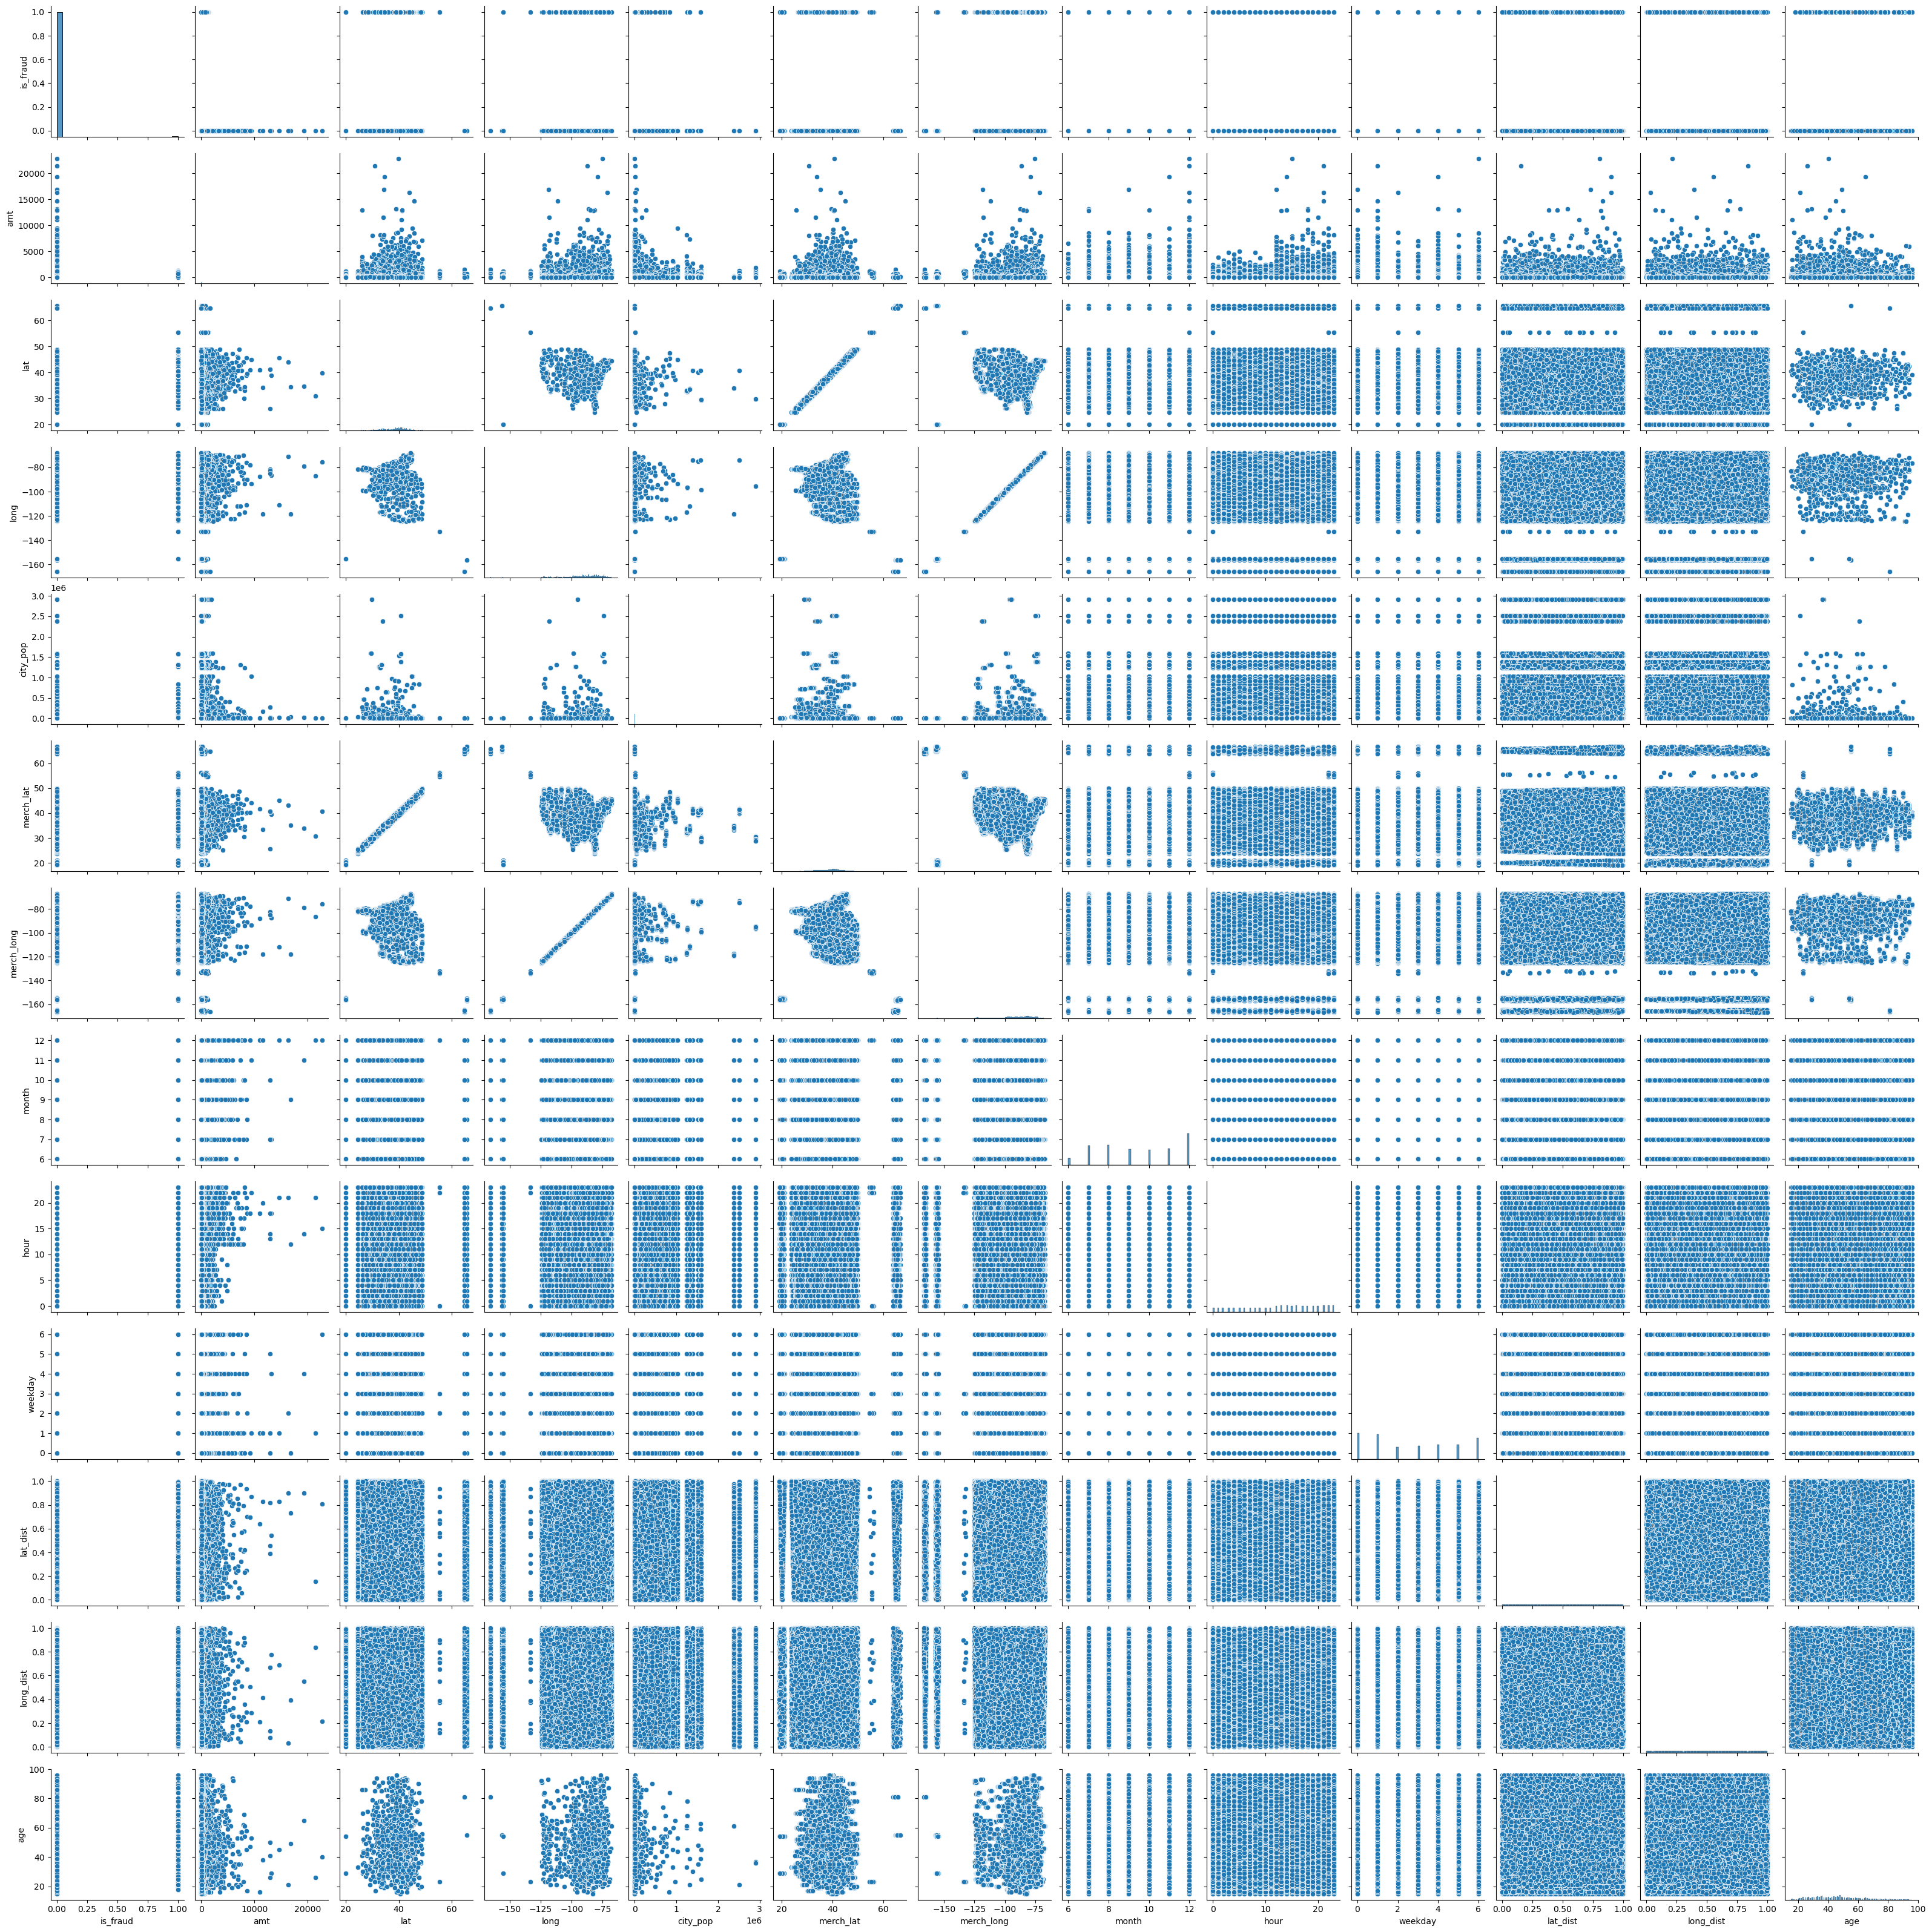

In [46]:
# Pairplot of the dataset

sns.pairplot(data=df_cc,
             vars=["is_fraud", "amt", "lat", "long", "city_pop", "merch_lat", "merch_long", "month", "hour", "weekday", "lat_dist", "long_dist", "age"]);

### Target variable relationship with transaction amount

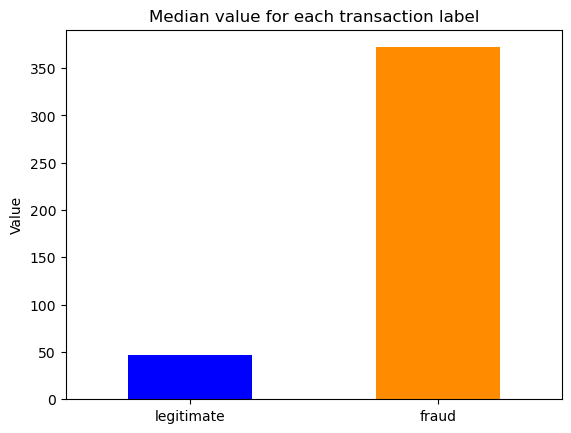

In [145]:
# Median amount value per type of transaction

df_cc.groupby("is_fraud")["amt"].median().plot(kind="bar", color=["blue", "darkorange"])
plt.title("Median value for each transaction label")
plt.xticks(ticks=[0, 1], labels = ["legitimate", "fraud"], rotation=0)
plt.ylabel("Value")
plt.xlabel(None);

In [43]:
# Check values for medians

df_cc.groupby("is_fraud")["amt"].median()

is_fraud
0     47.15
1    371.94
Name: amt, dtype: float64

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


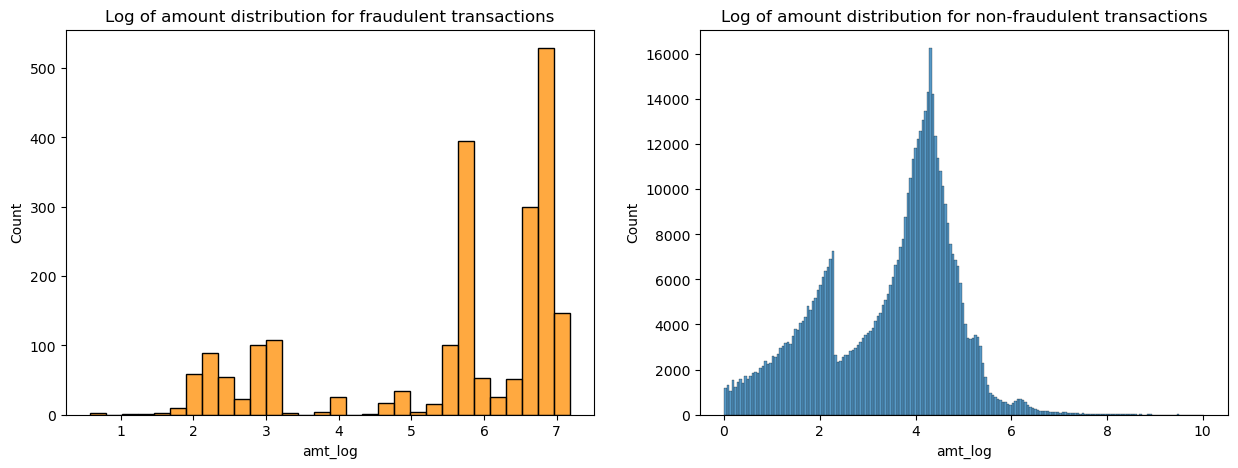

In [130]:
# Log of transaction amount distribution per transaction label

amt_log = df_cc[["amt", "is_fraud"]]

amt_log["amt_log"] = np.log(amt_log["amt"])

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 5))

ax0 = sns.histplot(data=amt_log[amt_log["is_fraud"] == 1], x="amt_log",  color="darkorange", ax=ax0)
ax1 = sns.histplot(data=amt_log[amt_log["is_fraud"] == 0], x="amt_log", ax=ax1)
ax0.set_title("Log of amount distribution for fraudulent transactions")
ax0.set_ylabel("Count")
ax1.set_title("Log of amount distribution for non-fraudulent transactions")
ax1.set_ylabel("Count");

Fraudulent transactions seems to be related to higher amount values. The plots show that the median transaction amount value for fradulent transactions (371.94) is higher than the median for the non-fraudulent (47.15). The histograms show information that points in the same direction, as the distribution of amt log for fraudulent transactions is more 
concentrated around log 6 and log 7, while amt log for legitimate transactions is more widespread and centered around log 4.
Finally, it is worth noting that the correlation matrix showed that that there is a linear relation with the target variable (r = 0.182267). Even though the value may seen small at first glance, it is possible that this value is being attenuated due to outliers. 

### Target variable relationship with gender, time related variables and category

In [202]:
# Fraud ("is_fraud" = 1) distribution among different genders

df_cc.groupby("gender")["is_fraud"].value_counts().unstack().iloc[:,1]

gender
F    1164
M     981
Name: 1, dtype: int64

In [206]:
df_cc.groupby("gender")["is_fraud"].value_counts(normalize=True).unstack("gender").iloc[1]

gender
F    0.003818
M    0.003911
Name: 1, dtype: float64

Text(0, 0.5, 'Percentage')

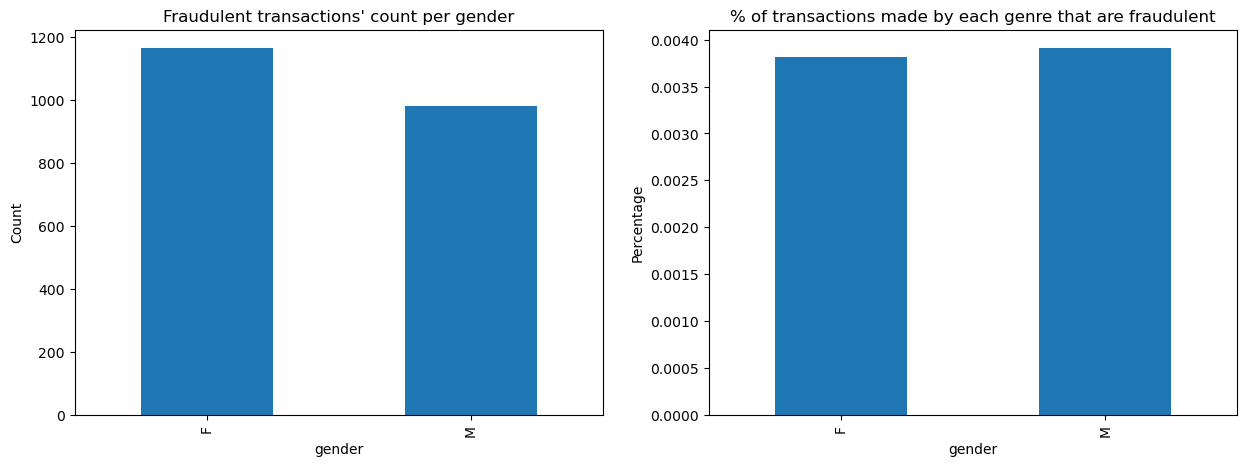

In [230]:
# Plot results

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 5))

ax0 = df_cc.groupby("gender")["is_fraud"].value_counts().unstack("gender").iloc[1].plot(kind="bar", ax=ax0)
ax1 = df_cc.groupby("gender")["is_fraud"].value_counts(normalize=True).unstack("gender").iloc[1].plot(kind="bar", ax=ax1)
ax0.set_title("Fraudulent transactions' count per gender")
ax0.set_ylabel("Count")
ax1.set_title("% of transactions made by each genre that are fraudulent")
ax1.set_ylabel("Percentage")


It is interesting to see that females have made more fraudulent transactions if we take the absolute number into account. However, if we take into consideration the proportion of all transactions made by each genre that are fraudulent, males are proportionally more represented.

In [264]:
# Fraud ("is_fraud" = 1) distribution among different months

df_cc.groupby("month")["is_fraud"].value_counts().unstack()

is_fraud       0    1
month                
6          29925  133
7          85527  321
8          88344  415
9          69193  340
10         68964  384
11         72341  294
12        139280  258

In [266]:
df_cc.groupby("month")["is_fraud"].value_counts(normalize=True).unstack()

is_fraud         0         1
month                       
6         0.995575  0.004425
7         0.996261  0.003739
8         0.995324  0.004676
9         0.995110  0.004890
10        0.994463  0.005537
11        0.995952  0.004048
12        0.998151  0.001849

''

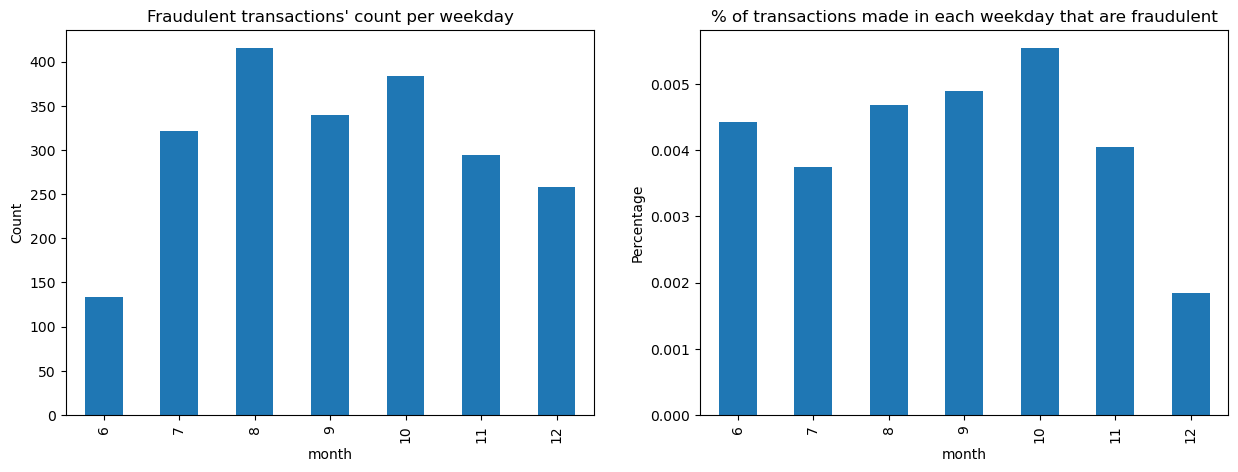

In [268]:
# Plot results

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 5))

ax0 = df_cc.groupby("month")["is_fraud"].value_counts().unstack().iloc[:,1].plot(kind="bar", ax=ax0)
ax1 = df_cc.groupby("month")["is_fraud"].value_counts(normalize=True).unstack().iloc[:,1].plot(kind="bar", ax=ax1)
ax0.set_title("Fraudulent transactions' count per month")
ax0.set_ylabel("Count")
ax1.set_title("% of transactions made in each month that are fraudulent")
ax1.set_ylabel("Percentage")
;

In [236]:
# Fraud ("is_fraud" = 1) distribution among different weekdays

df_cc.groupby("weekday")["is_fraud"].value_counts().unstack()

is_fraud       0    1
weekday              
0         114834  302
1         109782  331
2          52574  266
3          59147  309
4          62509  297
5          62004  266
6          92724  374

In [252]:
df_cc.groupby("weekday")["is_fraud"].value_counts(normalize=True).unstack()

is_fraud         0         1
weekday                     
0         0.997377  0.002623
1         0.996994  0.003006
2         0.994966  0.005034
3         0.994803  0.005197
4         0.995271  0.004729
5         0.995728  0.004272
6         0.995983  0.004017

''

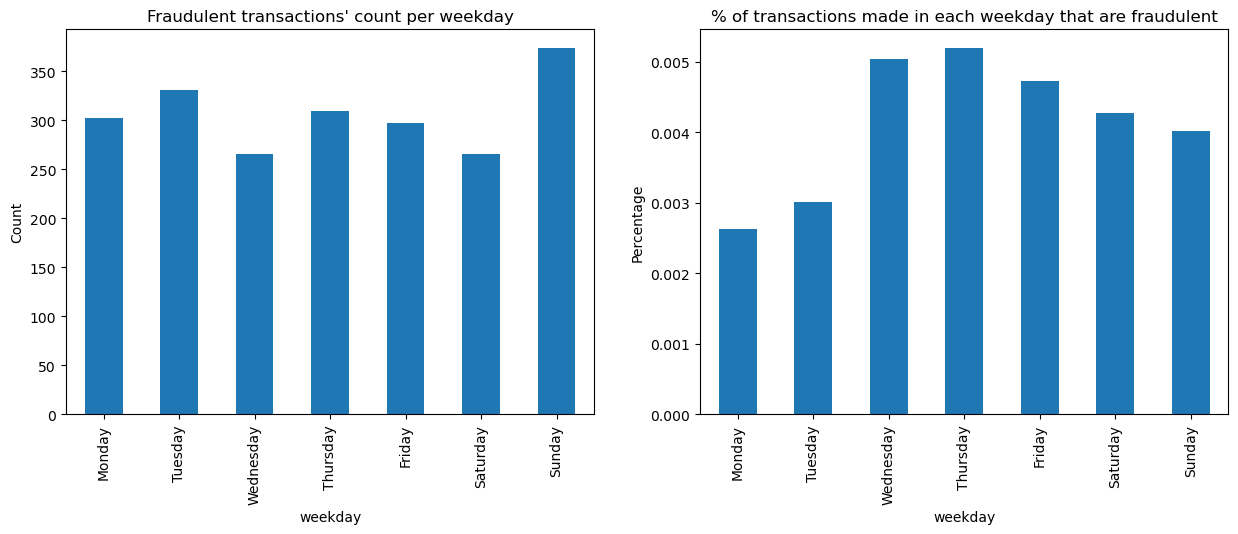

In [254]:
# Plot results

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 5))

ax0 = df_cc.groupby("weekday")["is_fraud"].value_counts().unstack().iloc[:,1].plot(kind="bar", ax=ax0)
ax1 = df_cc.groupby("weekday")["is_fraud"].value_counts(normalize=True).unstack().iloc[:,1].plot(kind="bar", ax=ax1)
ax0.set_title("Fraudulent transactions' count per weekday")
ax0.set_ylabel("Count")
ax0.set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax1.set_title("% of transactions made in each weekday that are fraudulent")
ax1.set_ylabel("Percentage")
ax1.set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
;

In [256]:
# Fraud ("is_fraud" = 1) distribution among different hours

df_cc.groupby("hour")["is_fraud"].value_counts().unstack()

is_fraud      0    1
hour                
0         17965  188
1         18292  169
2         17972  168
3         18005  194
4         18060   15
5         17897   20
6         18092   14
7         18082   16
8         17983   10
9         18032   14
10        18037   12
11        18071   17
12        28020   17
13        28164   14
14        28190   14
15        28027   21
16        28542   21
17        28048   16
18        27971   30
19        27901   24
20        27947   36
21        28178   27
22        27838  550
23        28260  538

In [258]:
df_cc.groupby("hour")["is_fraud"].value_counts(normalize=True).unstack()

is_fraud         0         1
hour                        
0         0.989644  0.010356
1         0.990846  0.009154
2         0.990739  0.009261
3         0.989340  0.010660
4         0.999170  0.000830
5         0.998884  0.001116
6         0.999227  0.000773
7         0.999116  0.000884
8         0.999444  0.000556
9         0.999224  0.000776
10        0.999335  0.000665
11        0.999060  0.000940
12        0.999394  0.000606
13        0.999503  0.000497
14        0.999504  0.000496
15        0.999251  0.000749
16        0.999265  0.000735
17        0.999430  0.000570
18        0.998929  0.001071
19        0.999141  0.000859
20        0.998714  0.001286
21        0.999043  0.000957
22        0.980626  0.019374
23        0.981318  0.018682

Text(0, 0.5, 'Percentage')

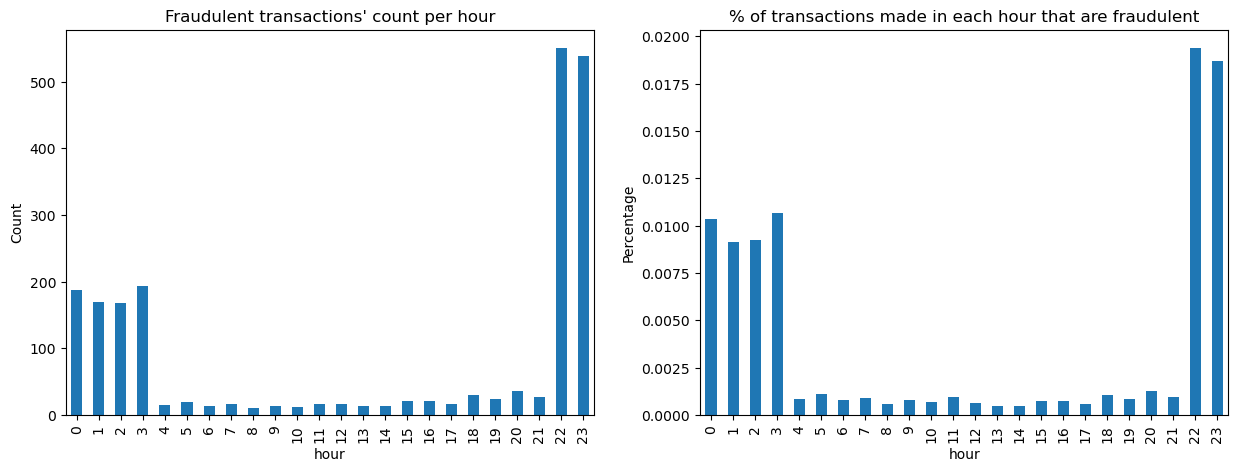

In [260]:
# Plot results

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 5))

ax0 = df_cc.groupby("hour")["is_fraud"].value_counts().unstack().iloc[:,1].plot(kind="bar", ax=ax0)
ax1 = df_cc.groupby("hour")["is_fraud"].value_counts(normalize=True).unstack().iloc[:,1].plot(kind="bar", ax=ax1)
ax0.set_title("Fraudulent transactions' count per hour")
ax0.set_ylabel("Count")
ax1.set_title("% of transactions made in each hour that are fraudulent")
ax1.set_ylabel("Percentage")

Most fraudlent transaction happened between 22:00 and 3:00.

In [40]:
# Fraud ("is_fraud" = 1) distribution among different categories

df_cc.groupby("category")["is_fraud"].value_counts().unstack()

is_fraud            0    1
category                  
entertainment   40045   59
food_dining     39214   54
gas_transport   56216  154
grocery_net     19385   41
grocery_pos     52068  485
health_fitness  36622   52
home            52278   67
kids_pets       48627   65
misc_net        27100  267
misc_pos        34502   72
personal_care   39257   70
shopping_net    41273  506
shopping_pos    49578  213
travel          17409   40

In [42]:
df_cc.groupby("category")["is_fraud"].value_counts(normalize=True).unstack()

is_fraud               0         1
category                          
entertainment   0.998529  0.001471
food_dining     0.998625  0.001375
gas_transport   0.997268  0.002732
grocery_net     0.997889  0.002111
grocery_pos     0.990771  0.009229
health_fitness  0.998582  0.001418
home            0.998720  0.001280
kids_pets       0.998665  0.001335
misc_net        0.990244  0.009756
misc_pos        0.997918  0.002082
personal_care   0.998220  0.001780
shopping_net    0.987889  0.012111
shopping_pos    0.995722  0.004278
travel          0.997708  0.002292

Text(0, 0.5, 'Percentage')

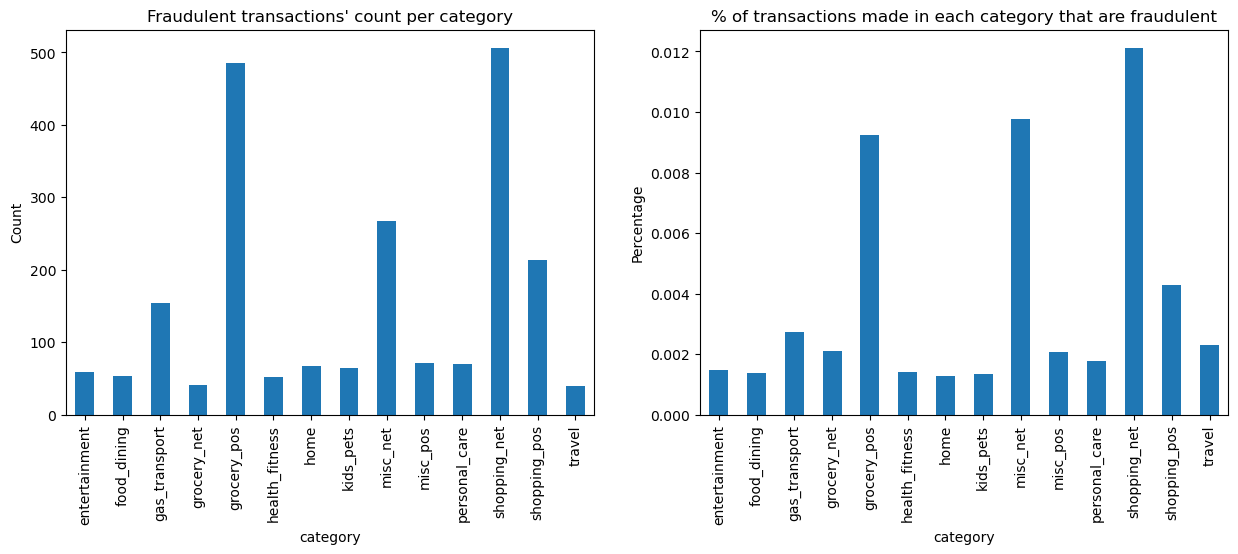

In [47]:
# Plot results

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 5))

ax0 = df_cc.groupby("category")["is_fraud"].value_counts().unstack().iloc[:,1].plot(kind="bar", ax=ax0)
ax1 = df_cc.groupby("category")["is_fraud"].value_counts(normalize=True).unstack().iloc[:,1].plot(kind="bar", ax=ax1)
ax0.set_title("Fraudulent transactions' count per category")
ax0.set_ylabel("Count")
ax1.set_title("% of transactions made in each category that are fraudulent")
ax1.set_ylabel("Percentage")

Some categories seems to be overrepresented when it comes to fraud. That is the case for "grocery_pos, "misc_net", "shopping_net", and "shopping_por".

### Profile Report

In [29]:
from ydata_profiling import ProfileReport

In [30]:
profile = ProfileReport(df_cc, title="Profile Report")

profile.to_file("your_report.html") # File will be submited with the project

In [ ]:
# To display the profile on my notebook requires too much of my computer memory and this cell should not be runned

profile.to_notebook_iframe()

### EDA summary
Some highlights of the EDA on the data:
- The label column ("is_fraud") is hugely imbalanced and the great majority of the observations refer to non-fraudulent transactions.
- Fraud has a small linear correlationship with transaction amount. Median values for amount differ greatly for fraudulent and non-fraudulent transactions and so does the distribution of values.
- Most fraudulent transactions happend between 22h and 3h.
- Fraud seems to be more prevalent in some cateories, as "grocery_pos, "misc_net", "shopping_net", and "shopping_por".

# Modeling

## Taking the frequency of fraud into account

In [37]:
df_cc['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

One thing worth noting in this dataset is that it is hugely imbalanced. Only 0.386% of the transactions are labeled as fraud (label "1"). Because of this, using accuracy as a metric might be deceiving as any model that predicts all transactions to be non-fraudulent would achieve an accuracy socre of 99.614%.

When considering other metrics, recall is particularly important. As there is more damage for the company in allowing a fraudulent transaction than in sending a transaction for human analisys, identifying correctly transactions labelled as fraud seems to be key. At the same time, blocking an excessive number of legitime transactions may impact customer satisfaction. This highlights the importance of keeping a reasonable balance between recall and precision. Thus, we will recall as the main evaluation metric and accuracy and precison as secondary ones.

## Data preprocessing

In [274]:
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cc_num      555719 non-null  object        
 1   merchant    555719 non-null  object        
 2   category    555719 non-null  object        
 3   amt         555719 non-null  float64       
 4   first       555719 non-null  object        
 5   last        555719 non-null  object        
 6   gender      555719 non-null  object        
 7   street      555719 non-null  object        
 8   city        555719 non-null  object        
 9   state       555719 non-null  object        
 10  zip         555719 non-null  int64         
 11  lat         555719 non-null  float64       
 12  long        555719 non-null  float64       
 13  city_pop    555719 non-null  int64         
 14  job         555719 non-null  object        
 15  dob         555719 non-null  datetime64[ns]
 16  tr

In [52]:
# Drop variables that won't be used for making predictions
# These represent information that is too widespread along a large number of categories, is redundant or 
# may no be accessible for a financial institution at the moment of the transaction
# Some of features removed might bear some importance (such as merchant), but the memory of my personal computer was not able to 
# handle a dataset with too many features

df_preprocessed = df_cc.copy()

df_preprocessed = df_preprocessed.drop(["cc_num", "merchant", "first", "last", "street", "city", "state", "zip", "lat", "long", 
                                        "city_pop", "dob", "job", "trans_num", "merch_lat", "merch_long"], axis=1)

In [54]:
# Encode categorical variables

df_preprocessed = pd.get_dummies(df_preprocessed, drop_first=True, dtype="int")

In [56]:
# Split data into training and test sets

X = df_preprocessed.drop("is_fraud", axis=1)
y = df_preprocessed[["is_fraud"]].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=2)

In [57]:
# Scale numerical features 

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [58]:
# Use oversample to deal with dataset imbalance

ros = RandomOverSampler(random_state=2)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train_full)

## Baseline models

In [72]:
# Logistic Regression baseline model

lr_scores = {"accuracy": [],
             "precision": [],
             "recall": [],
             "f1": []}

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Scale data

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_val)

    # Oversample to account for dataset target label imbalance

    ros = RandomOverSampler(random_state=2)
    X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

    lr_model = LogisticRegression(max_iter=500)
    lr_model.fit(X_resampled, y_resampled)
    
    lr_y_pred = lr_model.predict(X_test_scaled)

    lr_accuracy = accuracy_score(y_val, lr_y_pred)
    lr_scores["accuracy"].append(lr_accuracy)

    lr_precision = precision_score(y_val, lr_y_pred)
    lr_scores["precision"].append(lr_precision)

    lr_recall = recall_score(y_val, lr_y_pred)
    lr_scores["recall"].append(lr_recall)

    lr_f1 = f1_score(y_val, lr_y_pred)
    lr_scores["f1"].append(lr_f1)

print(f"Metrics for baseline Logistic Regression model:\n {pd.DataFrame(lr_scores).mean()}")

Metrics for baseline Logistic Regression model:
 accuracy     0.888032
precision    0.025402
recall       0.748845
f1           0.049126
dtype: float64


In [76]:
# Decision Tree baseline model

dt_scores = {"accuracy": [],
             "precision": [],
             "recall": [],
             "f1": []}

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=2)

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Scale data

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_val)

    # Oversample to account for dataset target label imbalance

    ros = RandomOverSampler(random_state=2)
    X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_resampled, y_resampled)
    
    dt_y_pred = dt_model.predict(X_test_scaled)

    dt_accuracy = accuracy_score(y_val, dt_y_pred)
    dt_scores["accuracy"].append(dt_accuracy)

    dt_precision = precision_score(y_val, dt_y_pred)
    dt_scores["precision"].append(dt_precision)

    dt_recall = recall_score(y_val, dt_y_pred)
    dt_scores["recall"].append(dt_recall)

    dt_f1 = f1_score(y_val, dt_y_pred)
    dt_scores["f1"].append(dt_f1)

print(f"Metrics for baseline Decision Tree model:\n {pd.DataFrame(dt_scores).mean()}")

Metrics for baseline Decision Tree model:
 accuracy     0.998172
precision    0.781086
recall       0.732260
f1           0.755277
dtype: float64


### Explaining baseline models

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


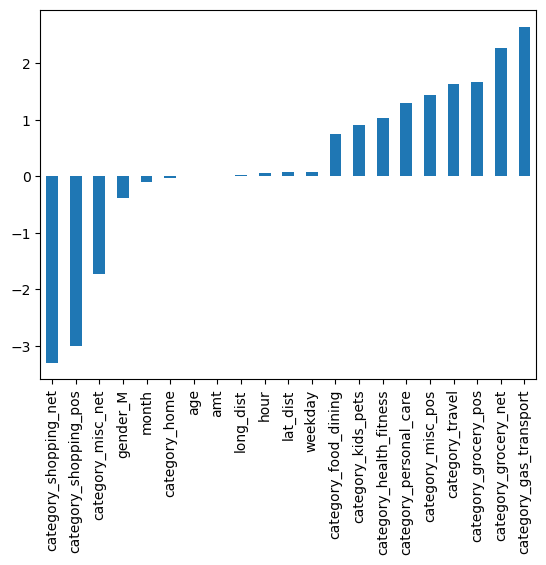

In [84]:
# LR model

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_resampled, y_resampled)
pd.Series(lr_model.coef_[0], index=X.columns).sort_values().plot(kind='bar');

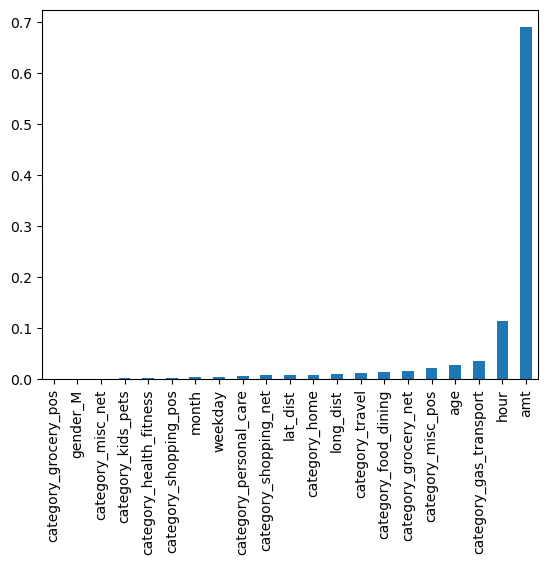

In [86]:
# DT model

dt_model = DecisionTreeClassifier()
dt_model.fit(X_resampled, y_resampled)
pd.Series(dt_model.feature_importances_, index=X.columns).sort_values().plot(kind='bar');

### Baseline models summary

## Setting a goal

Considering the performance of the baseline models and the context, it is important to set a goal for the models that will be created. For this project we will try to keep the accuracy at the 99% mark, while reaching a recall of at least 90%. This means that at least 99% of the predictions made by the model have to be right and at least 90% of attemps of fraud will be identified by the model.

## Training a deep learning model

In [105]:
# Defining model architecture

model = Sequential()
model.add(Dense(64, input_shape=(21,),activation='relu')) # first hidden layer needs an input shape
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid')) # output - in this case a binary classification output

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [107]:
# Define loss function, optimizer, metrics and compile model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

In [128]:
# Split the data into training, validation and test set

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=2)

In [323]:
# Scale data

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Oversample to account for dataset target label imbalance

ros = RandomOverSampler(random_state=2)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

In [134]:
history = model.fit(X_resampled, y_resampled, validation_data=(X_val_scaled, y_val), epochs=20)

Epoch 1/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9439 - loss: 0.1289 - precision: 0.9332 - recall: 0.9561 - val_accuracy: 0.9701 - val_loss: 0.0678 - val_precision: 0.1065 - val_recall: 0.9114
Epoch 2/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.9632 - loss: 0.0916 - precision: 0.9544 - recall: 0.9729 - val_accuracy: 0.9722 - val_loss: 0.0602 - val_precision: 0.1117 - val_recall: 0.8928
Epoch 3/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 145s 7ms/step - accuracy: 0.9692 - loss: 0.0788 - precision: 0.9610 - recall: 0.9781 - val_accuracy: 0.9783 - val_loss: 0.0497 - val_precision: 0.1374 - val_recall: 0.8741
Epoch 4/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 130s 6ms/step - accuracy: 0.9736 - loss: 0.0693 - precision: 0.9665 - recall: 0.9813 - val_accuracy: 0.9752 - val_loss: 0.0583 - val_precision: 0.1241 - val_recall: 0.8974
Epoch 5/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 134s 6ms/step - accuracy: 0.9750 - loss: 0.0661 - precision: 0.9685 - recall: 0.9819 - val_ac

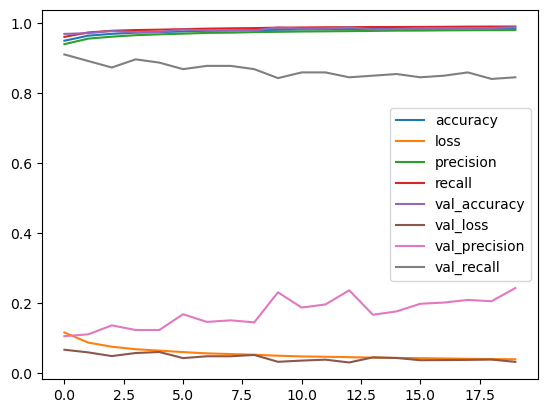

In [136]:
pd.DataFrame(history.history).plot();

In [389]:
pd.DataFrame(history.history).tail(1)

accuracy      loss  precision    recall  val_accuracy  val_loss  \
19  0.986116  0.040507   0.981063  0.991368      0.989284  0.033065   

    val_precision  val_recall  
19       0.243952    0.846154

In [138]:
# Defining model 2 architecture

model_2 = Sequential()
model_2.add(Dense(4, input_shape=(21,),activation='relu')) # first hidden layer needs an input shape
model_2.add(Dense(8,activation='relu')) 
model_2.add(Dense(4,activation='relu'))
model_2.add(Dense(1,activation='sigmoid')) # output - in this case a binary classification output

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [143]:
history_2 = model_2.fit(X_resampled, y_resampled, validation_data=(X_val_scaled, y_val), epochs=20)

Epoch 1/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 292s 14ms/step - accuracy: 0.9635 - loss: 0.0875 - precision: 0.9594 - recall: 0.9678 - val_accuracy: 0.9551 - val_loss: 0.0997 - val_precision: 0.0767 - val_recall: 0.9627
Epoch 2/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 355s 17ms/step - accuracy: 0.9637 - loss: 0.0870 - precision: 0.9596 - recall: 0.9682 - val_accuracy: 0.9596 - val_loss: 0.0956 - val_precision: 0.0836 - val_recall: 0.9510
Epoch 3/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.9636 - loss: 0.0870 - precision: 0.9594 - recall: 0.9680 - val_accuracy: 0.9595 - val_loss: 0.0969 - val_precision: 0.0841 - val_recall: 0.9604
Epoch 4/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.9643 - loss: 0.0855 - precision: 0.9603 - recall: 0.9685 - val_accuracy: 0.9585 - val_loss: 0.0938 - val_precision: 0.0810 - val_recall: 0.9441
Epoch 5/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9639 - loss: 0.0857 - precision: 0.9600 - recall: 0.9682 - val_ac

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



20759/20759 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9650 - loss: 0.0839 - precision: 0.9609 - recall: 0.9694 - val_accuracy: 0.9475 - val_loss: 0.1165 - val_precision: 0.0664 - val_recall: 0.9650
Epoch 11/20
 1349/20759 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9648 - loss: 0.0834 - precision: 0.9623 - recall: 0.9684

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



20759/20759 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9654 - loss: 0.0835 - precision: 0.9618 - recall: 0.9692 - val_accuracy: 0.9637 - val_loss: 0.0877 - val_precision: 0.0923 - val_recall: 0.9534
Epoch 14/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9653 - loss: 0.0828 - precision: 0.9620 - recall: 0.9691 - val_accuracy: 0.9544 - val_loss: 0.1038 - val_precision: 0.0749 - val_recall: 0.9534
Epoch 17/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9654 - loss: 0.0831 - precision: 0.9619 - recall: 0.9691 - val_accuracy: 0.9582 - val_loss: 0.0985 - val_precision: 0.0815 - val_recall: 0.9580
Epoch 18/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9655 - loss: 0.0820 - precision: 0.9620 - recall: 0.9694 - val_accuracy: 0.9628 - val_loss: 0.0888 - val_precision: 0.0905 - val_recall: 0.9557
Epoch 19/20
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9660 - loss: 0.0822 - precision: 0.9623 - recall: 0.9701 - val_accuracy: 0.9

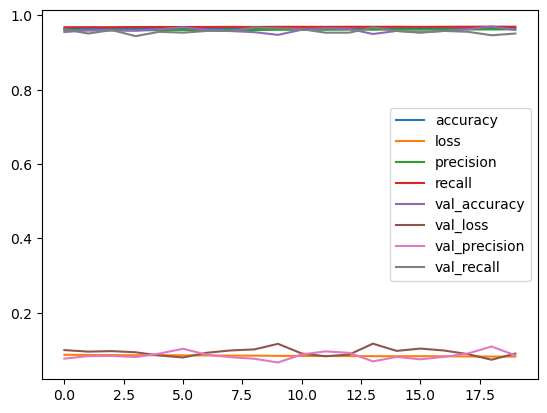

In [145]:
pd.DataFrame(history_2.history).plot();

In [321]:
pd.DataFrame(history_2.history).tail(1)

accuracy      loss  precision    recall  val_accuracy  val_loss  \
19  0.965681  0.082251   0.962268  0.969372      0.960637  0.090301   

    val_precision  val_recall  
19       0.085678    0.951049

In [159]:
# Defining model 3 architecture

model_3 = Sequential()
model_3.add(Dense(200, input_shape=(21,),activation='relu')) # first hidden layer needs an input shape
model_3.add(Dropout(0.2))
model_3.add(Dense(200,activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(128,activation='relu')) 
model_3.add(Dropout(0.2))
model_3.add(Dense(128,activation='relu')) 
model_3.add(Dropout(0.2))
model_3.add(Dense(128,activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(1,activation='sigmoid')) # output - in this case a binary classification output

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [161]:
history_3 = model_3.fit(X_resampled, y_resampled, validation_data=(X_val_scaled, y_val), epochs=100)

Epoch 1/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.8845 - loss: 0.2474 - precision: 0.8769 - recall: 0.8937 - val_accuracy: 0.9386 - val_loss: 0.1316 - val_precision: 0.0533 - val_recall: 0.8904
Epoch 2/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.9667 - loss: 0.0852 - precision: 0.9576 - recall: 0.9765 - val_accuracy: 0.9730 - val_loss: 0.0631 - val_precision: 0.1115 - val_recall: 0.8625
Epoch 3/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.9776 - loss: 0.0614 - precision: 0.9705 - recall: 0.9850 - val_accuracy: 0.9799 - val_loss: 0.0476 - val_precision: 0.1431 - val_recall: 0.8438
Epoch 4/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.9832 - loss: 0.0480 - precision: 0.9779 - recall: 0.9888 - val_accuracy: 0.9847 - val_loss: 0.0396 - val_precision: 0.1811 - val_recall: 0.8415
Epoch 5/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9858 - loss: 0.0420 - precision: 0.9811 - recall: 0.9907 - val_a

In [355]:
pd.DataFrame(history_3.history).tail(1)

accuracy      loss  precision    recall  val_accuracy  val_loss  \
99  0.994644  0.023532   0.992379  0.996944       0.99542  0.060524   

    val_precision  val_recall  
99       0.448454    0.811189

Even though training a model with a complex architecture for a bigger number of epochs resulted in improvements, the recall of the model still seems insufficient.
Next will be another try of with a smaller architecture, a larger number of epochs and learning rate.

In [178]:
# Defining model 4 architecture

model_4 = Sequential()
model_4.add(Dense(4, input_shape=(21,),activation='relu')) # first hidden layer needs an input shape
model_4.add(Dense(8,activation='relu')) 
model_4.add(Dense(4,activation='relu'))
model_4.add(Dense(1,activation='sigmoid')) # output - in this case a binary classification output

model_4.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy', 'precision', 'recall'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_4 = model_4.fit(X_resampled, y_resampled, validation_data=(X_val_scaled, y_val), epochs=100)

Epoch 1/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.8831 - loss: 0.2615 - precision: 0.8733 - recall: 0.8976 - val_accuracy: 0.9331 - val_loss: 0.2026 - val_precision: 0.0486 - val_recall: 0.8788
Epoch 2/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.9144 - loss: 0.1837 - precision: 0.9095 - recall: 0.9205 - val_accuracy: 0.9618 - val_loss: 0.1364 - val_precision: 0.0805 - val_recall: 0.8531
Epoch 3/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.9160 - loss: 0.1782 - precision: 0.9107 - recall: 0.9224 - val_accuracy: 0.8914 - val_loss: 0.1941 - val_precision: 0.0331 - val_recall: 0.9604
Epoch 4/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9182 - loss: 0.1744 - precision: 0.9113 - recall: 0.9269 - val_accuracy: 0.9078 - val_loss: 0.1533 - val_precision: 0.0379 - val_recall: 0.9394
Epoch 5/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.9201 - loss: 0.1720 - precision: 0.9115 - recall: 0.9309 - val_a

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



20759/20759 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.9282 - loss: 0.1605 - precision: 0.9097 - recall: 0.9508 - val_accuracy: 0.8945 - val_loss: 0.1548 - val_precision: 0.0339 - val_recall: 0.9580
Epoch 70/100
17183/20759 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9280 - loss: 0.1609 - precision: 0.9090 - recall: 0.9510

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



20759/20759 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9285 - loss: 0.1594 - precision: 0.9091 - recall: 0.9522 - val_accuracy: 0.8983 - val_loss: 0.1562 - val_precision: 0.0351 - val_recall: 0.9580
Epoch 74/100
 7205/20759 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9286 - loss: 0.1614 - precision: 0.9091 - recall: 0.9533

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



20759/20759 ━━━━━━━━━━━━━━━━━━━━ 24400s 1s/step - accuracy: 0.9281 - loss: 0.1609 - precision: 0.9082 - recall: 0.9525 - val_accuracy: 0.8944 - val_loss: 0.1932 - val_precision: 0.0341 - val_recall: 0.9650
Epoch 79/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9287 - loss: 0.1599 - precision: 0.9107 - recall: 0.9510 - val_accuracy: 0.9093 - val_loss: 0.1475 - val_precision: 0.0391 - val_recall: 0.9534
Epoch 80/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9286 - loss: 0.1604 - precision: 0.9099 - recall: 0.9520 - val_accuracy: 0.9082 - val_loss: 0.1523 - val_precision: 0.0385 - val_recall: 0.9510
Epoch 81/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.9280 - loss: 0.1611 - precision: 0.9088 - recall: 0.9515 - val_accuracy: 0.9099 - val_loss: 0.1414 - val_precision: 0.0392 - val_recall: 0.9510
Epoch 82/100
20759/20759 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.9275 - loss: 0.1612 - precision: 0.9081 - recall: 0.9513 - val_accurac

In [185]:
pd.DataFrame(history_4.history).tail(1)

accuracy      loss  precision    recall  val_accuracy  val_loss  \
99    0.9282  0.160447   0.908659  0.952108      0.910261   0.12979   

    val_precision  val_recall  
99       0.039023    0.941725

### Training a deep learning model summary

In [419]:
pd.concat(
    [pd.DataFrame(history.history).tail(1),
     pd.DataFrame(history_2.history).tail(1),
     pd.DataFrame(history_3.history).tail(1),
     pd.DataFrame(history_4.history).tail(1)]
).reset_index(drop=True).rename(index={0: 'model_1', 1: "model_2", 2: "model_3", 3: "model_4"})

accuracy      loss  precision    recall  val_accuracy  val_loss  \
model_1  0.986116  0.040507   0.981063  0.991368      0.989284  0.033065   
model_2  0.965681  0.082251   0.962268  0.969372      0.960637  0.090301   
model_3  0.994644  0.023532   0.992379  0.996944      0.995420  0.060524   
model_4  0.928200  0.160447   0.908659  0.952108      0.910261  0.129790   

         val_precision  val_recall  
model_1       0.243952    0.846154  
model_2       0.085678    0.951049  
model_3       0.448454    0.811189  
model_4       0.039023    0.941725

Even though the neural network models might suit the problem at hand better than the baseline models, none of the deep learning models were able to reach the goal. 

However, it is worth noting that if more time were available the models might be improved and reach the goal. The deepest neural networks performed fairly and the experimentation with different parameters can produce improvements. Setting new training parameters (such as optimizer, learning rate, number of epochs) might solve the issue.

In [ ]:
''' 
If one of these is the best model, evalue on test set:
model.evaluate(X_test,y_test)
'''

## Training a XGBoost model

In [ ]:
# Convert training data to DMatrix dtype

dtrain = xgb.DMatrix(data=X_resampled, label=y_resampled)

In [423]:
# Define model parameters

params = {
    'objective':'binary:logistic',
    'learning_rate':0.001
}

num_rounds = 1000

In [425]:
# Train the model

xbg_model = xgb.train(params, dtrain, num_rounds)

In [426]:
# Evaluate on the validation data

y_val_preds = (xbg_model.predict(dval) > 0.5).astype('int')

In [427]:
pd.DataFrame({"accuracy": [accuracy_score(y_val, y_val_preds)], 
              "precision": [precision_score(y_val, y_val_preds)],
              "recall": [recall_score(y_val, y_val_preds)]})

accuracy  precision    recall
0  0.974547   0.127792  0.960373

In [443]:
# Increasing treeshoold for labeling observation as fraud to try to improve precision / accuracy

y_val_preds = (xbg_model.predict(dval) > 0.7).astype('int')

In [445]:
pd.DataFrame({"accuracy": [accuracy_score(y_val, y_val_preds)], 
              "precision": [precision_score(y_val, y_val_preds)],
              "recall": [recall_score(y_val, y_val_preds)]})

accuracy  precision    recall
0  0.990193    0.27128  0.913753

Finally, the XGBoost with a higher threeshold for labeling fraud was able to reach the goal. \
It is still possible to improve this model by parameter tuning.

In [455]:
# Define new set of parameters

params = {
    'objective':'binary:logistic',
    'max_depth': 10,
    'learning_rate':0.001
}

num_rounds = 1000

In [457]:
# Train the model

xbg_model = xgb.train(params, dtrain, num_rounds)

In [458]:
# Evaluate on validation data

y_val_preds = (xbg_model.predict(dval) > 0.5).astype('int')

pd.DataFrame({"accuracy": [accuracy_score(y_val, y_val_preds)], 
              "precision": [precision_score(y_val, y_val_preds)],
              "recall": [recall_score(y_val, y_val_preds)]})

accuracy  precision    recall
0  0.988501   0.242883  0.934732

In [459]:
y_val_preds = (xbg_model.predict(dval) > 0.6).astype('int')

pd.DataFrame({"accuracy": [accuracy_score(y_val, y_val_preds)], 
              "precision": [precision_score(y_val, y_val_preds)],
              "recall": [recall_score(y_val, y_val_preds)]})

accuracy  precision   recall
0  0.990652   0.283381  0.93007

In [ ]:
# Parameter tunning

In [573]:
# Set parameters to be used in experimentation

params_fixed = {
    'objective': 'binary:logistic',
}

params_grid = {
    'max_depth': [5, 10, 15]
    'learning_rate': [0.1, 0.01, 0.001]
}

In [624]:
# Train a model for each combination of these parameters and evaluate them on validation dataset

dtrain = xgb.DMatrix(data=X_resampled, label=y_resampled)
dval = xgb.DMatrix(X_val_scaled)
max_depths = [5, 10, 15]
learning_rates = [0.1, 0.01, 0.001]
counter = 1
num_rounds = 1000
results = []

for depth in max_depths:
    for lr in learning_rates:
        params = {
        'objective':'binary:logistic',
        'max_depth': depth,
        'learning_rate': lr
        }        
        xbg_model = xgb.train(params, dtrain, num_rounds)
        print(f"Finished training model {counter}")
        y_val_preds = (xbg_model.predict(dval) > 0.5).astype('int')
        results_df = pd.DataFrame({"depth": [depth],
                      "lr": [lr],
                      "accuracy": [accuracy_score(y_val, y_val_preds)], 
                      "precision": [precision_score(y_val, y_val_preds)],
                      "recall": [recall_score(y_val, y_val_preds)]})
        results.append(results_df)
        counter += 1

Finished training model 1
Finished training model 2
Finished training model 3
Finished training model 4
Finished training model 5
Finished training model 6
Finished training model 7
Finished training model 8
Finished training model 9


In [646]:
# Inspect the results of the models

results_df = pd.concat(results).sort_values(["recall", "accuracy"], ascending=False).reset_index(drop=True)

results_df["f1"] = 2 * (results_df["precision"] * results_df["recall"]) / (results_df["precision"] + results_df["recall"])

results_df

depth     lr  accuracy  precision    recall        f1
0      5  0.010  0.986657   0.220276  0.967366  0.358841
1      5  0.001  0.944127   0.062774  0.967366  0.117898
2     10  0.001  0.988501   0.242883  0.934732  0.385577
3     15  0.001  0.992892   0.341528  0.906760  0.496173
4     10  0.010  0.997625   0.644483  0.857809  0.736000
5      5  0.100  0.998264   0.742798  0.841492  0.789071
6     10  0.100  0.998731   0.851220  0.813520  0.831943
7     15  0.010  0.998273   0.757050  0.813520  0.784270
8     15  0.100  0.998614   0.831325  0.804196  0.817536

### Experimentation with the models that achieved the highest recall and highest f1 scores

In [648]:
# Retrain the model with highest recall

params = {
    'objective':'binary:logistic',
    'max_depth': 5,
    'learning_rate':0.01
}

num_rounds = 1000

xbg_model = xgb.train(params, dtrain, num_rounds)

In [654]:
# Evaluate it along different tresholds for labeling fraud

tresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_best_recall_model = []

for treshold in tresholds:
    y_val_preds = (xbg_model.predict(dval) > treshold).astype('int')

    results_per_treshold = pd.DataFrame({"threshold": threshold,
                                            "accuracy": [accuracy_score(y_val, y_val_preds)], 
                                            "precision": [precision_score(y_val, y_val_preds)],
                                            "recall": [recall_score(y_val, y_val_preds)]})

    results_best_recall_model.append(results_per_treshold)

In [655]:
pd.concat(results_best_recall_model)

threshold  accuracy  precision    recall
0        0.1  0.915821   0.043469  0.990676
0        0.2  0.956822   0.080936  0.983683
0        0.3  0.973422   0.124814  0.979021
0        0.4  0.982212   0.175608  0.976690
0        0.5  0.986657   0.220276  0.967366
0        0.6  0.989302   0.260404  0.962704
0        0.7  0.991255   0.300514  0.953380
0        0.8  0.993981   0.385057  0.937063
0        0.9  0.996662   0.541193  0.888112

In [658]:
# Retrain the model with highest f1

params = {
    'objective':'binary:logistic',
    'max_depth': 10,
    'learning_rate':0.1
}

num_rounds = 1000

xbg_model = xgb.train(params, dtrain, num_rounds)

In [660]:
# Evaluate it along different tresholds for labeling fraud

tresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_best_f1_model = []

for treshold in tresholds:
    y_val_preds = (xbg_model.predict(dval) > threshold).astype('int')

    results_per_treshold = pd.DataFrame({"threshold": treshold,
                                            "accuracy": [accuracy_score(y_val, y_val_preds)], 
                                            "precision": [precision_score(y_val, y_val_preds)],
                                            "recall": [recall_score(y_val, y_val_preds)]})

    results_best_f1_model.append(results_per_treshold)

In [661]:
pd.concat(results_best_recall_model)

threshold  accuracy  precision    recall
0        0.1  0.915821   0.043469  0.990676
0        0.2  0.956822   0.080936  0.983683
0        0.3  0.973422   0.124814  0.979021
0        0.4  0.982212   0.175608  0.976690
0        0.5  0.986657   0.220276  0.967366
0        0.6  0.989302   0.260404  0.962704
0        0.7  0.991255   0.300514  0.953380
0        0.8  0.993981   0.385057  0.937063
0        0.9  0.996662   0.541193  0.888112

Considering the goal setted, the best scores achieved in the validation dataset by a model is accuracy = 0.991255, precision 0.300514, recall = 0.953380. This score was achieved by two of the models trained (both the model with param max_depth = 5  lr = 0.01, and max_depth = 10 lr = 0.1) when using the treshold of 0.7 probability to predict an instance as being a fraudulent transaction. \
Next, the best model should be scored using the test dataset. As simplicity is a desirable trait of a model, the model with lower max_depth will be used for this. 

In [737]:
#  Evaluate the best model on the test dataset

params = {
    'objective':'binary:logistic',
    'max_depth': 5,
    'learning_rate':0.01
}

num_rounds = 1000

# Retrain model with best params

xgb_model_final = xgb.train(params, dtrain, num_rounds)

In [843]:
# Convert X_test_scaled to dmatrix

dtest = xgb.DMatrix(X_test_scaled)
dtest.feature_names = X.columns.to_list()

# Evaluate on test data using 0.7 as treshold for fraud prediction

y_test_preds = (xgb_model_final.predict(dtest) > 0.7).astype('int')

print("Score of the best model on the test dataset")
pd.DataFrame({"accuracy": [accuracy_score(y_test, y_test_preds)], 
              "precision": [precision_score(y_test, y_test_preds)],
              "recall": [recall_score(y_test, y_test_preds)],
              "f1": [f1_score(y_test, y_test_preds)]})

Score of the best model on the test dataset


accuracy  precision    recall        f1
0   0.99103   0.290869  0.920746  0.442082

## Explaining the best model (XGBoost)

In [745]:
# Assign the correct name to each feature

xgb_model_final.feature_names = X.columns.tolist()

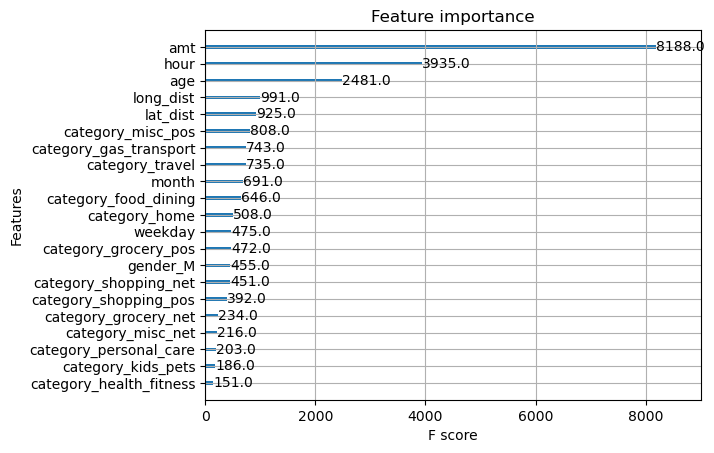

In [747]:
# Plot the importance

xgb.plot_importance(xgb_model_final)
fig = plt.gcf()

In [950]:
# Explain the model using SHAP

explainer_model = xgb.XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01, objective='binary:logistic').fit(X_resampled, y_resampled)

In [960]:
explainer_model.get_booster().feature_names = X.columns.to_list()

In [998]:
explainer = shap.Explainer(explainer_model, feature_names=X.columns.to_list())
shap_values = explainer(X_resampled)

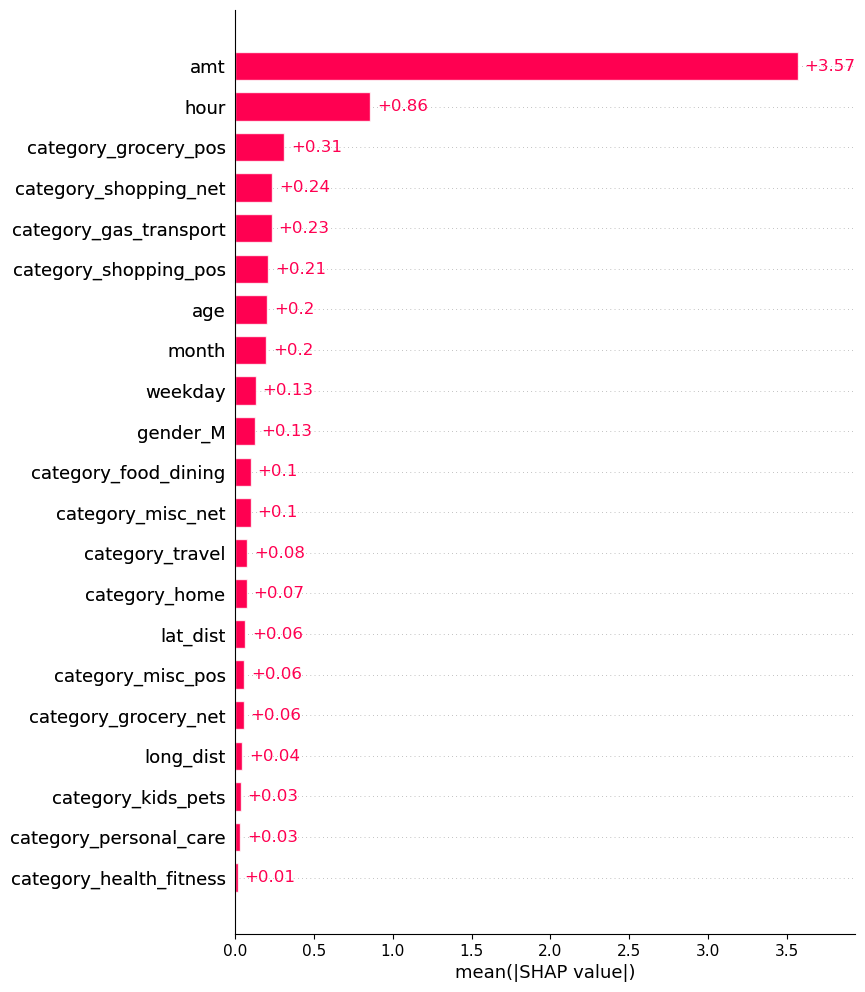

In [999]:
shap.plots.bar(shap_values, max_display=30)

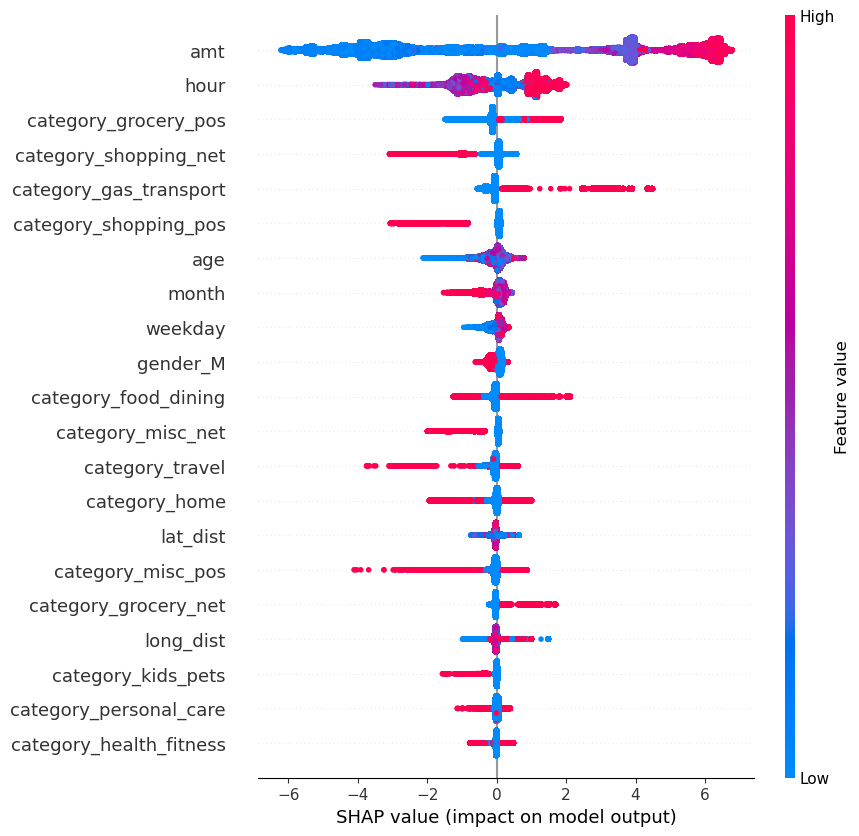

In [1004]:
shap.plots.beeswarm(shap_values, max_display=30)

### Training a XGBoost model summary
The final XGBoost model trained was able to reach the goal of 99% accuracy and 90% or more recall. Its scores on the test model were accuracy = 099103, precision = 0.290869, recall = 0.920746, f1 = 0.442082. This means that about 99,1% predtiction made by the model on the test data were correct and it was able to capture 92% of the frauds. The breakdown of the importance of each feature to the model shows that trasanction amount and the hour the transaction took place were the information the model values the most.

# Extra: using a pipeline 
Throughout the notebook pipelines were not used because the RandomOverSampler does not have a fit() and transform() methods from sklearn. However, this could have been done by building a customized pipeline.

In [78]:
# Example of customized pipeline that could be applied (traning a model and scoring on validation dataset)

from imblearn.pipeline import make_pipeline

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=2)

scaling = MinMaxScaler()
sampling= RandomOverSampler()
modeling = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01, objective='binary:logistic')

my_pipeline = make_pipeline(scaling, sampling, modeling)

my_pipeline.fit(X_train, y_train)

y_val_preds = (my_pipeline.predict_proba(X_val) > 0.7)[:,1].astype('int')

pd.DataFrame({"accuracy": [accuracy_score(y_val, y_val_preds)], 
              "precision": [precision_score(y_val, y_val_preds)],
              "recall": [recall_score(y_val, y_val_preds)]})

accuracy  precision   recall
0  0.991713   0.312214  0.95338

# Closing remarks
This project was aimed at building a machine learning model for fraud detection. Based on the context and baseline models, the goal as set at a model that could reach at least 99% accuracy and 90% recall. To achieved this, a set of neural network models and XGBoost model were built. The model that performed the best on the validation set was the XGBoost with parameter max_depth = 5 = learning_rate: 0.01 and a treshold of 0.7 or more to predict an instance as being fraud. The score of this model of the test dataset was accuracy = 099103, precision = 0290869, recall = 0.920746, f1 = 0.442082. The features that influence its the predictions most were trasanction amount, the hour the transaction took place, and the age of the card holder at the moment of the transaction. \

This result have to be considered within the context of a company. Even though 92% recall seems to be great at first glance, the business can have an even higher expectation and further exploration of models could be done parameter tuning, trying diifferent kinds of neural networks, and so on. \

In case this model is satisfactory, some final business recomendations would be:

- Deploy the model for company everyday use. If performance is as expected, the model should be able to prevent about 92% of fraud attemps in an automated way.
- Test the suggested model in the real world and verify if it can achieve the 99% accuracy and 90% recall that were set as the initial goal. If performed it less than expected, further exploration of models can and should be performed.
- Constinuously refine and improve the model to be used based on new data collected after its implementation.
- The explanation of the model suggest that the transaction amount value and hour of transaction might be particularly when is comes to fraud. The company should investigate further if it is worth to take some fraud prevention action using this features (i.e. adding extra security steps to transaction made within a certain time frame or that goes beyond a certain value).
